# Figures Notebook

## Packages

We begin by loading in necessary software packages and introducing options for saving the results.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as pe

import netCDF4 as nc4
import numpy as np
import pandas as pd
import logging

import pystan

In [2]:
# use test data (not all data is used for fitting/training)
use_testdata = False

# create plots of the data
show_data = True

# netCDF input file
input_name = '../results/zinser_results_window_combined.nc'

# write out generated plots
save_plots = True

prior_only = False

plot_fitted = False

## Load Data

In [3]:
# load processed data
datafile = '../data/size_distribution/zinser_processed.nc'

dataname = 'zinser'

desc = 'Culture dataset'

# Indices of data to hold out for hold-out validation
# Uncomment desired line and set use_testdata to true
itestfile = None
# itestfile = '../data/hold_out/keep_twothirds.csv'
# itestfile = '../data/hold_out/keep_half.csv'
# itestfile = '../data/hold_out/keep_onethird.csv'

size_units = 'fg C cell$^{-1}$'


def get_data(datafile, size_units, itestfile, dataname, desc, extend=False):
    
    data_gridded = {}
    with nc4.Dataset(datafile) as nc:
        for var in nc.variables:
            data_gridded[var] = nc.variables[var][:]

    # create "counts" entry
    if 'count' in data_gridded:
        data_gridded['counts'] = (data_gridded['count'][None,:]
                                  * data_gridded['w_obs']).astype(int)
    elif 'abundance' in data_gridded:
        logging.warning('Using "abundance" data to generate count data for the model.')
        data_gridded['counts'] = (data_gridded['count'][None,:]
                                  * data_gridded['w_obs']).astype(int)
    else:
        raise RuntimeError('Cannot find a "count" or "abundance" entry in "{}".'.format(datafile))
    
    if extend:
        data_gridded['time'] = np.concatenate((data_gridded['time'],
                                               (data_gridded['time']
                                               + data_gridded['time'][-1]
                                               + data_gridded['time'][1])[:-1]))
        
        for item in ('w_obs', 'PAR', 'abundance', 'count', 'counts'):
            if len(data_gridded[item].shape) == 2:
                data_gridded[item] = np.concatenate((data_gridded[item],
                                                     data_gridded[item][:, 1:]), axis=1)
            else:
                data_gridded[item] = np.concatenate((data_gridded[item],
                                                     data_gridded[item][1:]))

    # add description
    desc += ' (m={data[m]}, $\Delta_v^{{-1}}$={data[delta_v_inv]})'.format(data=data_gridded)
    
    return data_gridded, desc

data_gridded, desc = get_data(datafile, size_units, itestfile, dataname, desc, extend=True)

In [4]:
# Ground truth division, carbon fixation, carbon loss measured/estimated from the Zinser et al. dataset
ground_truth = {}
with nc4.Dataset('../data/ground_truth/zinser_ground_truth.nc') as nc:
    for var in nc.variables:
        ground_truth[var] = nc.variables[var][:]

# Measurements and standard errors including photosynthetic parameters from Zinser et al. paper figure 3
zinser_fig3 = pd.read_csv('../data/ground_truth/zinser_figure3.csv')

## Process Data

In [5]:
# prepare data for Stan model
def data_prep(data_gridded, dt=20, limit_days=2, start=0, use_testdata=False,
              itestfile=None, prior_only=False):
    
    data = {'dt':dt}
    for v in ('m','v_min','delta_v_inv'):
        data[v] = data_gridded[v]

    data['obs'] = data_gridded['w_obs']
    data['t_obs'] = data_gridded['time']
    par = data_gridded['PAR']

    if limit_days > 0:
        limit_minutes = limit_days*1440

        ind_obs = (start*60 <= data['t_obs']) & (data['t_obs'] < limit_minutes+start*60)

        if not np.all(ind_obs):
            print('start is set to {}, limit_days is set to {}, removing {}/{} observation times'.format(start,
                                                                                                         limit_days,
                                                                                                         ind_obs.size
                                                                                                         -np.count_nonzero(ind_obs),
                                                                                                         ind_obs.size))

        data['t_obs'] = data['t_obs'][ind_obs]
        data['obs'] = data['obs'][:,ind_obs]

        data['nt'] = int(limit_minutes//data['dt']+1)

    data['nt_obs'] = data['t_obs'].size

    if use_testdata:
        # load cross-validation testing indices and add them to data
        data['i_test'] = np.loadtxt(itestfile).astype(int)
        # remove last index, so that dimensions agree
        data['i_test'] = data['i_test'][:-1]
    else:
        # set all indices to zero
        data['i_test'] = np.zeros(data['nt_obs'], dtype=int)

    # switch on or off data fitting
    data['prior_only'] = int(prior_only)

    # add light data
    t = np.arange(data['nt'])*data['dt'] + start*60
    data['E'] = np.interp(t, xp=data_gridded['time'][ind_obs], fp=par[ind_obs])

    # real count data
    data['obs_count'] = data_gridded['counts'][:, ind_obs]
    
    data['start'] = start

    # consistency check
    if len(data['i_test']) != data['nt_obs']:
        raise ValueError('Invalid number of testing indices (expected {}, got {}).'.format(data['nt_obs'],
                                                                                       len(data['i_test'])))
    return data


data = data_prep(data_gridded, dt=20, limit_days=4, start=0,
                 use_testdata=use_testdata, itestfile=itestfile,
                 prior_only=prior_only)

start is set to 0, limit_days is set to 4, removing 1/49 observation times


## Load Results

In [6]:
mcmcs = {}
with nc4.Dataset(input_name) as nc:
    models = nc.groups.keys()
    for name in models:
        windows = nc[name].groups.keys()
        if name not in mcmcs.keys():
            mcmcs[name] = {}
        for window in windows:
            if window not in mcmcs[name].keys():
                mcmcs[name][window] = {}
            for var in nc[name][window].variables:
                mcmcs[name][window][var] = nc[name][window].variables[var][:]

In [7]:
models = ['m_bmx', 'm_bmb', 'm_pmb', 'm_fmb', 'm_fmf', 'm_btb', 'm_ptb', 'm_ftb', 'm_ftf']

## Some Plotting Parameters

In [8]:
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['legend.fontsize'] = 8
mpl.rcParams['axes.titlesize'] = 9
mpl.rcParams['figure.figsize'] = (7.5,7.5)
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'

In [9]:
prop_labels = {
    'size':'cell size (fg C cell$^{-1}$)',
    'growth':'carbon fixation (fg C cell$^{-1}$ h$^{-1}$)',
    'growthresp':'carbon fixation and loss\n(fg C cell$^{-1}$ h$^{-1}$)',
    'division':'division rate (h$^{-1}$)',
    'respiration':'carbon loss (fg C cell$^{-1}$ h$^{-1}$)',
    'abundance':'abundance (cells ml$^{-1}$)',
    'light':'PAR ($\\mu$mol photons m$^{-2}$ s$^{-1}$)',
}

v_min = data_gridded['v_min']
delta_v = 1/data_gridded['delta_v_inv']

size_bound_edges = v_min * 2**(np.arange(data_gridded['m'] + 1) * delta_v)

# Plot grid parameters
show_grid = True
grid_width = 0.3
which_grid = 'both'
grid_axis = 'x'
grid_color = 'grey'
grid_style = '--'

mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['xtick.labelsize'] = 6
mpl.rcParams['ytick.labelsize'] = 6
mpl.rcParams['mathtext.default'] = 'regular'
mpl.rcParams['font.size'] = 9
mpl.rcParams['grid.color'] = grid_color
mpl.rcParams['grid.linestyle'] = grid_style
mpl.rcParams['grid.linewidth'] = grid_width

#
# plotting
#


def add_colorbar(ax, label=None, labelcolor='0.9', **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='40%', loc='upper left',
                            bbox_to_anchor=(0.0,0.0,1,1),
                            bbox_transform=ax.transAxes)
    cb = mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical',
                                   **cbarargs)
    cb.set_label(label, color=labelcolor)
    for ytl in cb.ax.get_yticklabels():
        ytl.set_color(labelcolor)
    cb.ax.tick_params(axis='y', colors=labelcolor)
    cb.outline.set_edgecolor(labelcolor)
            
            
if plot_fitted:
    for name in mcmcs:
        for window in tuple(mcmcs[name].keys()):

            start = int(window)
            duration = len(mcmcs[name][window]['obstime'])
            t = data_gridded['time'][start//2:(start//2+duration)]/60
            t_edges = np.empty(t.size+1)
            t_edges[1:-1] = 0.5 * (t[1:] +t[:-1])
            t_edges[0] = 0.5 * (t[0] - t[1])
            t_edges[-1] = t[-1] + 0.5*(t[-1]-t[-2])
            
            print(np.mean(mcmcs[name][window]['divrate']))

            fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7.5, 5), squeeze=False)

            ax_celldist = axs[0, 0]
            ax_model = axs[1, 0]

            #
            # pcolor
            #

            for iax,ax in enumerate([ax_celldist, ax_model]):
                if ax is None:
                    continue

                if iax == 0:
                    tmp = data_gridded['w_obs'][:, start//2:(start//2+duration)]
                    label = 'proportion'
                    ax.set_title('Model {} Prediction Start Time {} hours duration {} hours'.format(name,
                                                                                                    window,
                                                                                                    duration*2))
                else:
                    unnorm = np.mean(mcmcs[name][window]['mod_obspos'], axis=0)
                    tmp = unnorm / np.sum(unnorm, axis=0)
                    label = 'proportion'

                norm = mpl.colors.Normalize(vmin=0.0)
                pc = ax.pcolormesh(t_edges, size_bound_edges, tmp, norm=norm,
                                   rasterized=True)

                add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label=label, extend='max')

                ax.set_ylabel(prop_labels['size'])
                ax.set_xlim(start, start+duration*2)
                ax.set_xlabel('Time (hours)')
            if window == '0':
                plt.savefig('../figures/rollingwindow{}{}.pdf'.format(name, duration), bbox_inches='tight', dpi=300)
            plt.show()
            plt.close()

In [10]:
def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5,
                            bbox_to_anchor=(0.05,0.0,1,1),
                            bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical',
                              **cbarargs)

if 'size_units' not in globals():
    size_units = 'fg C cell$^{-1}$'

prop_labels = {
    'growth':'cell growth ({} h$^{{-1}}$)'.format(size_units),
    'division':'division rate (h$^{-1}$)',
    'respiration':'respiration + exudation\n({} h$^{{-1}}$)'.format(size_units),
}

if show_data:
    v_min = data_gridded['v_min']
    delta_v = 1.0/data_gridded['delta_v_inv']
    v = v_min * 2**(np.arange(data_gridded['m'])*delta_v)
    v_carbon = v*np.sqrt(2**(delta_v))

# Figures

### Daily parameter plot

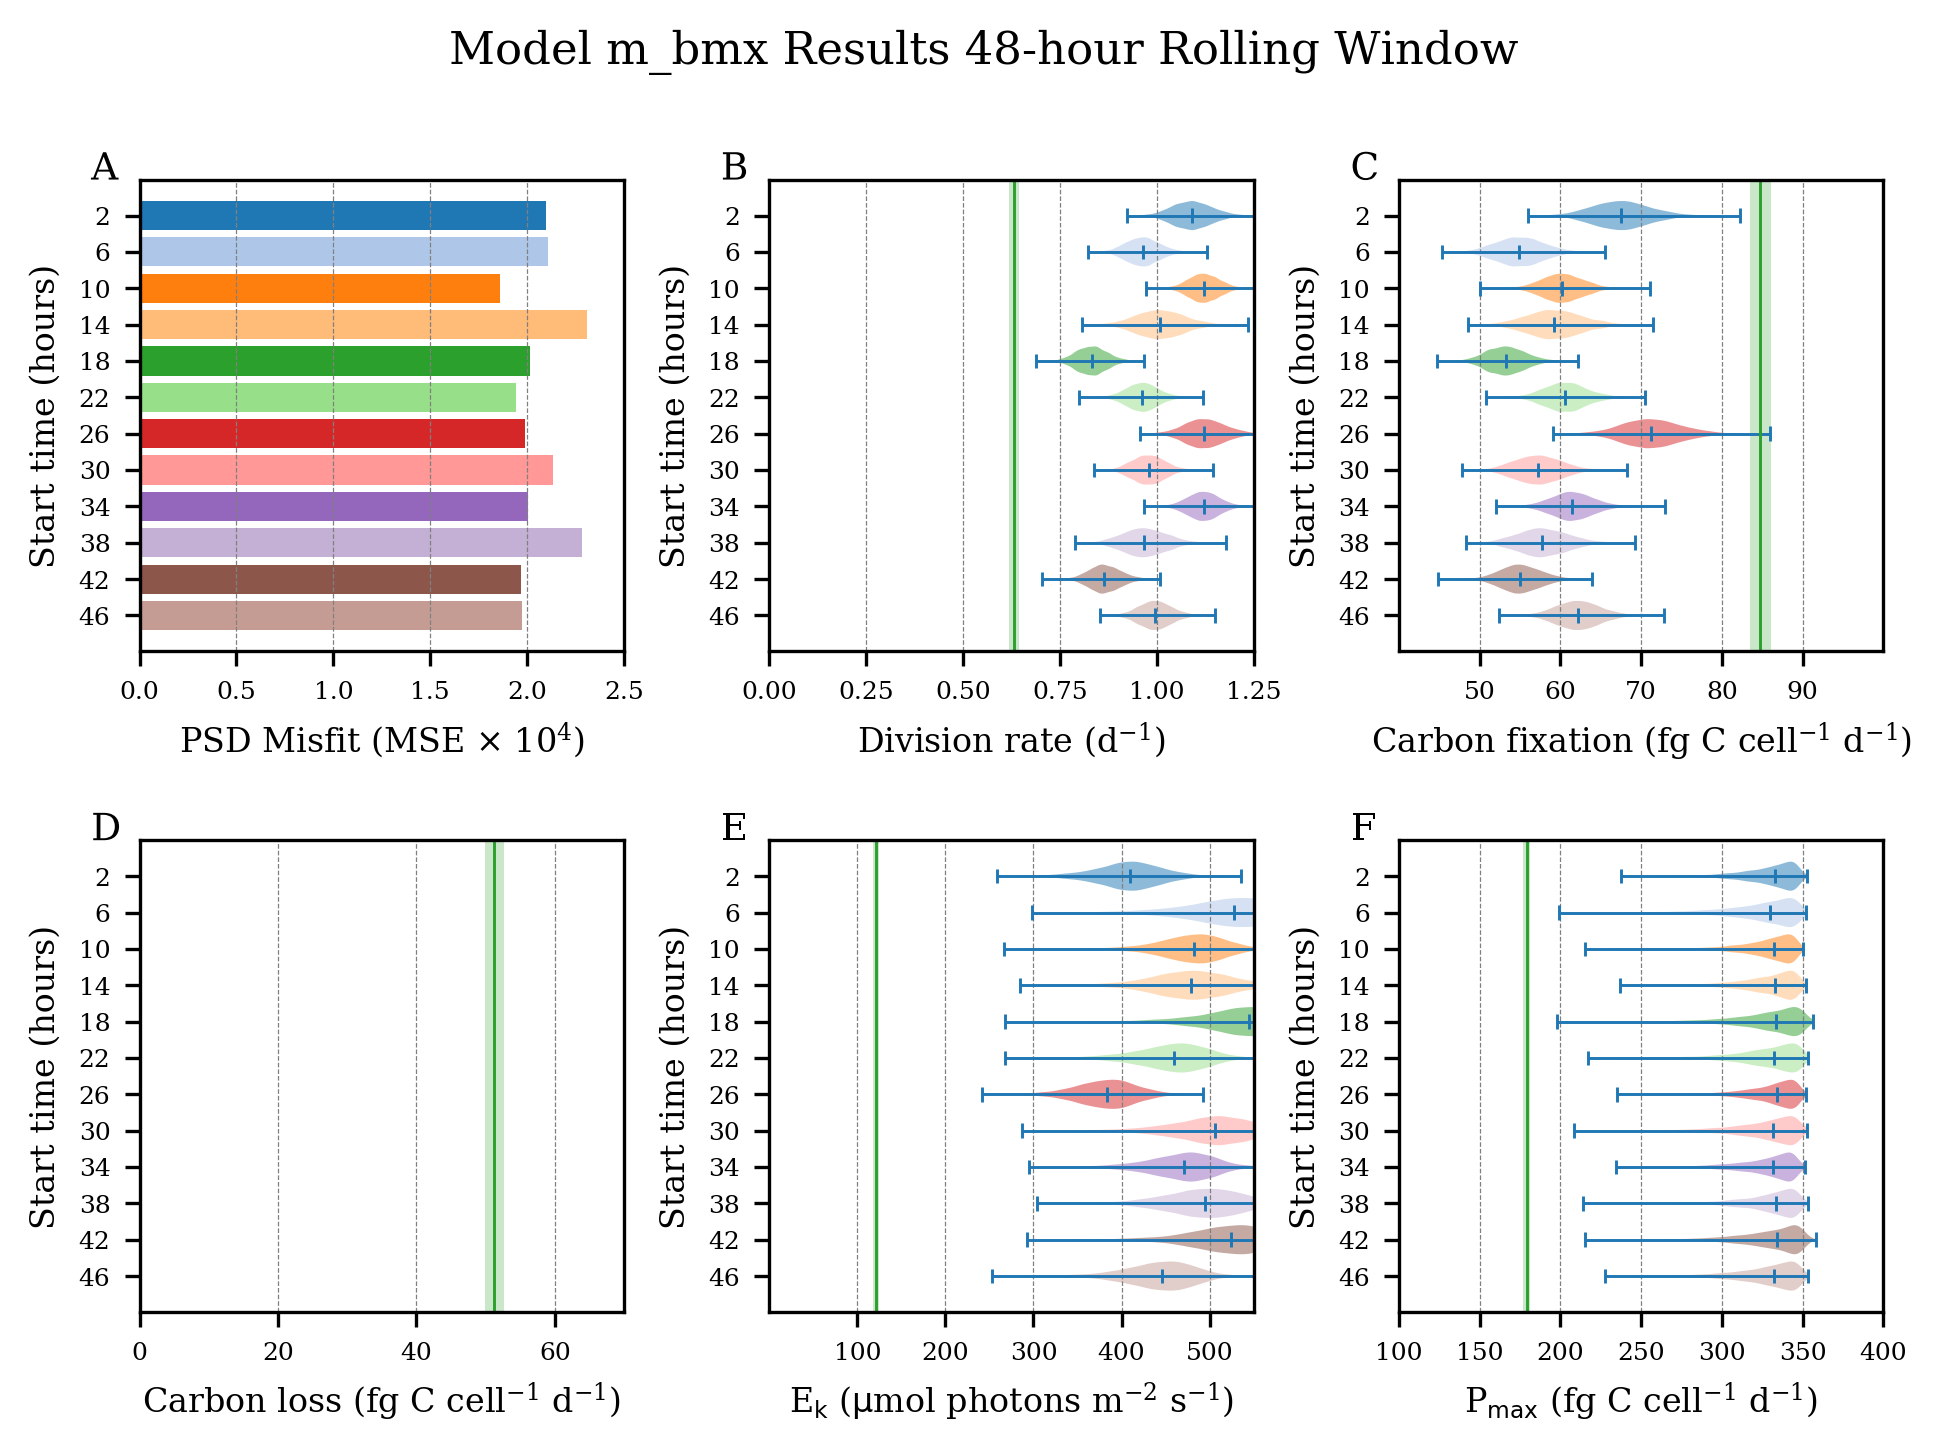

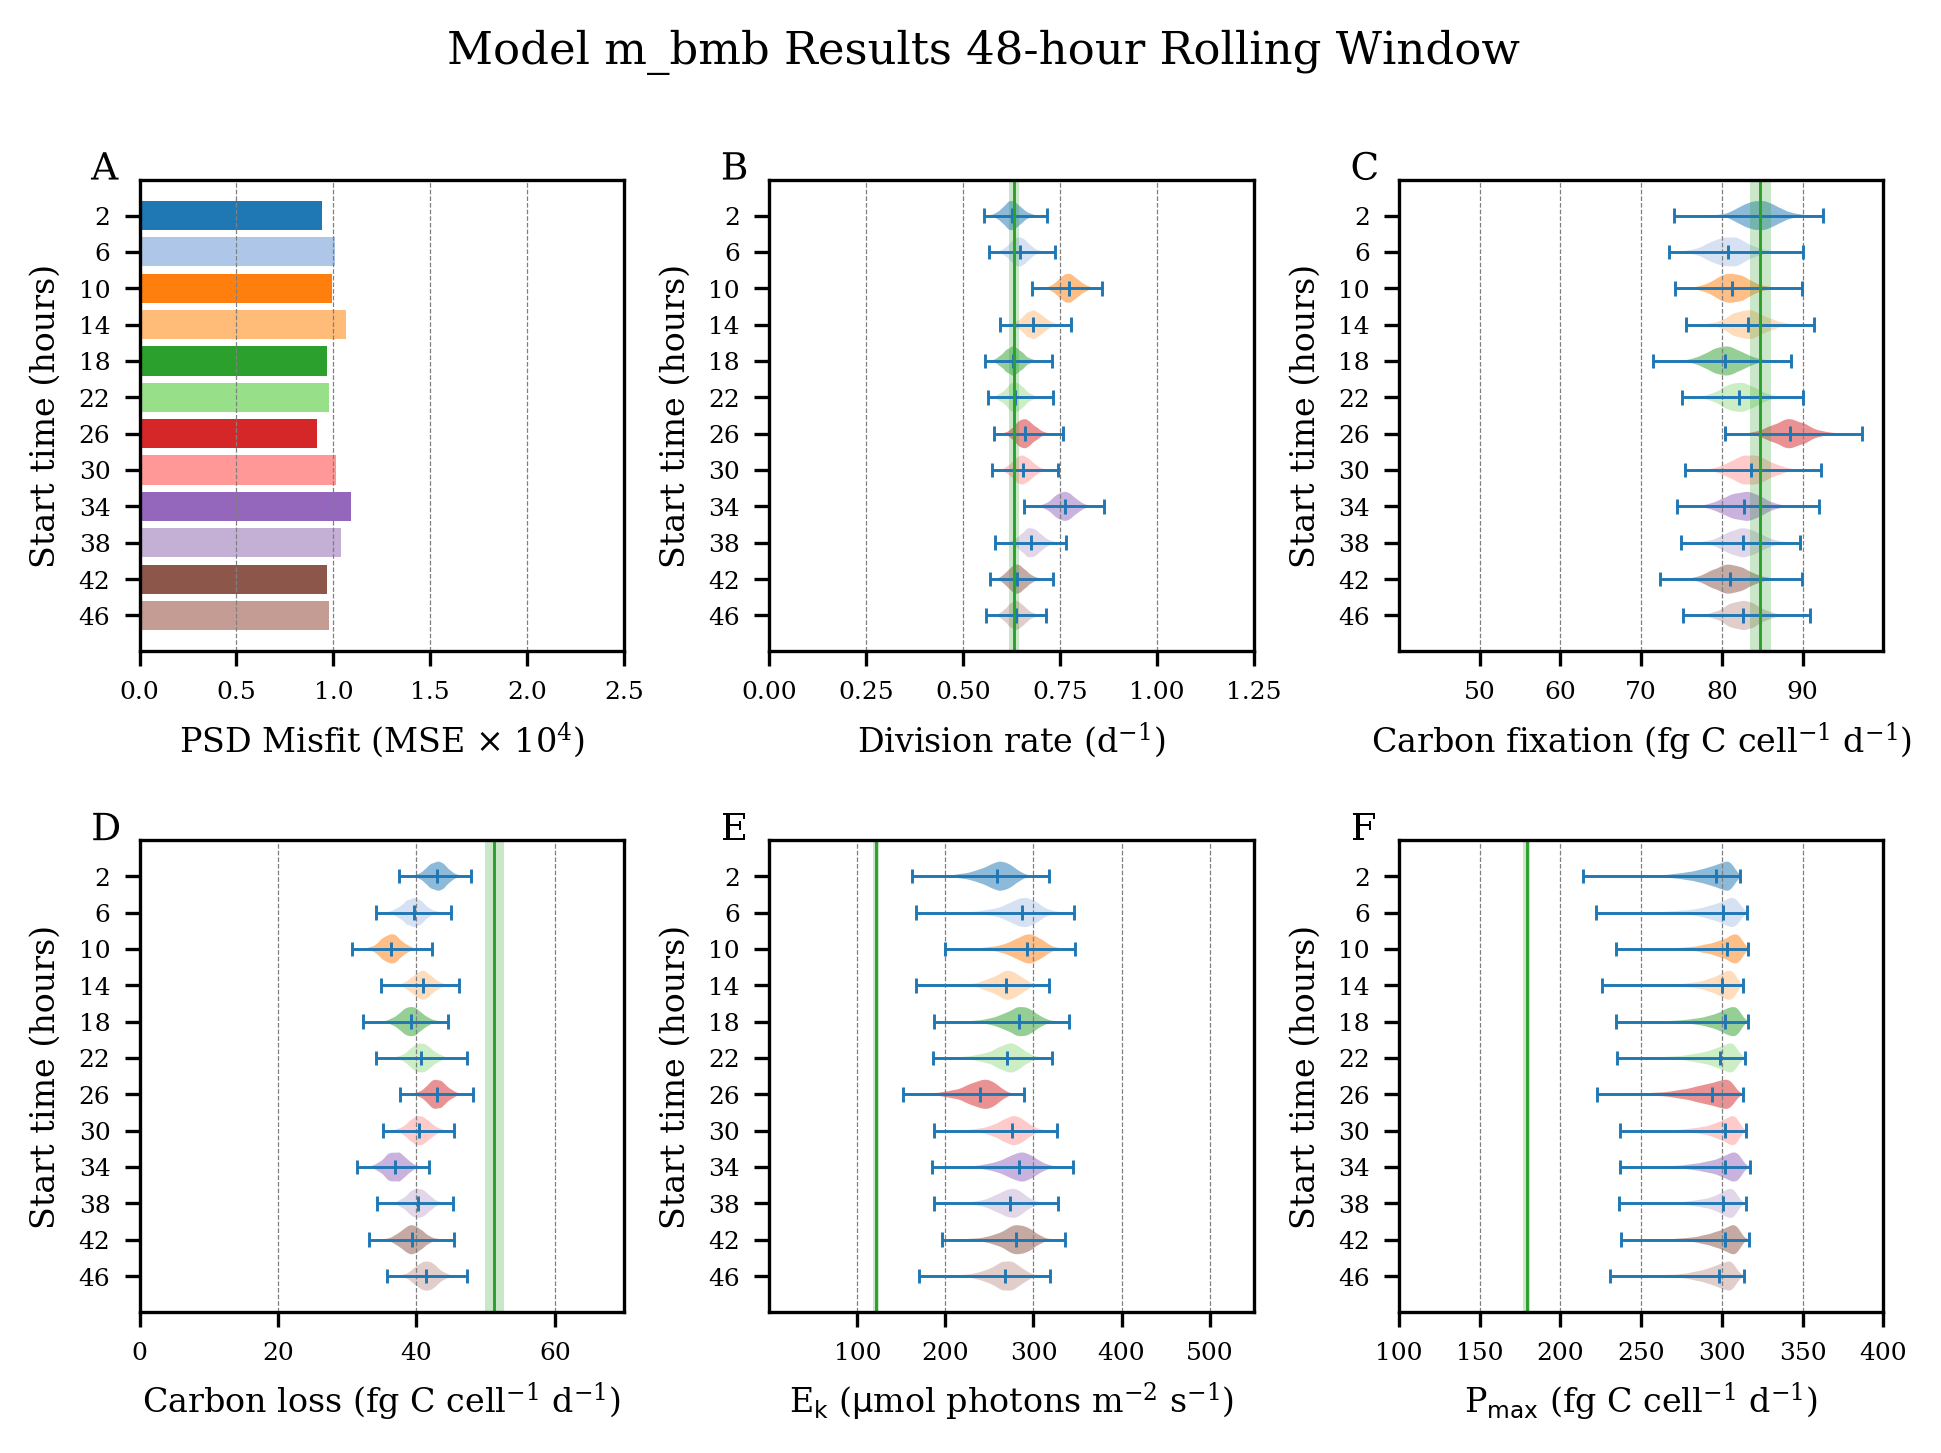

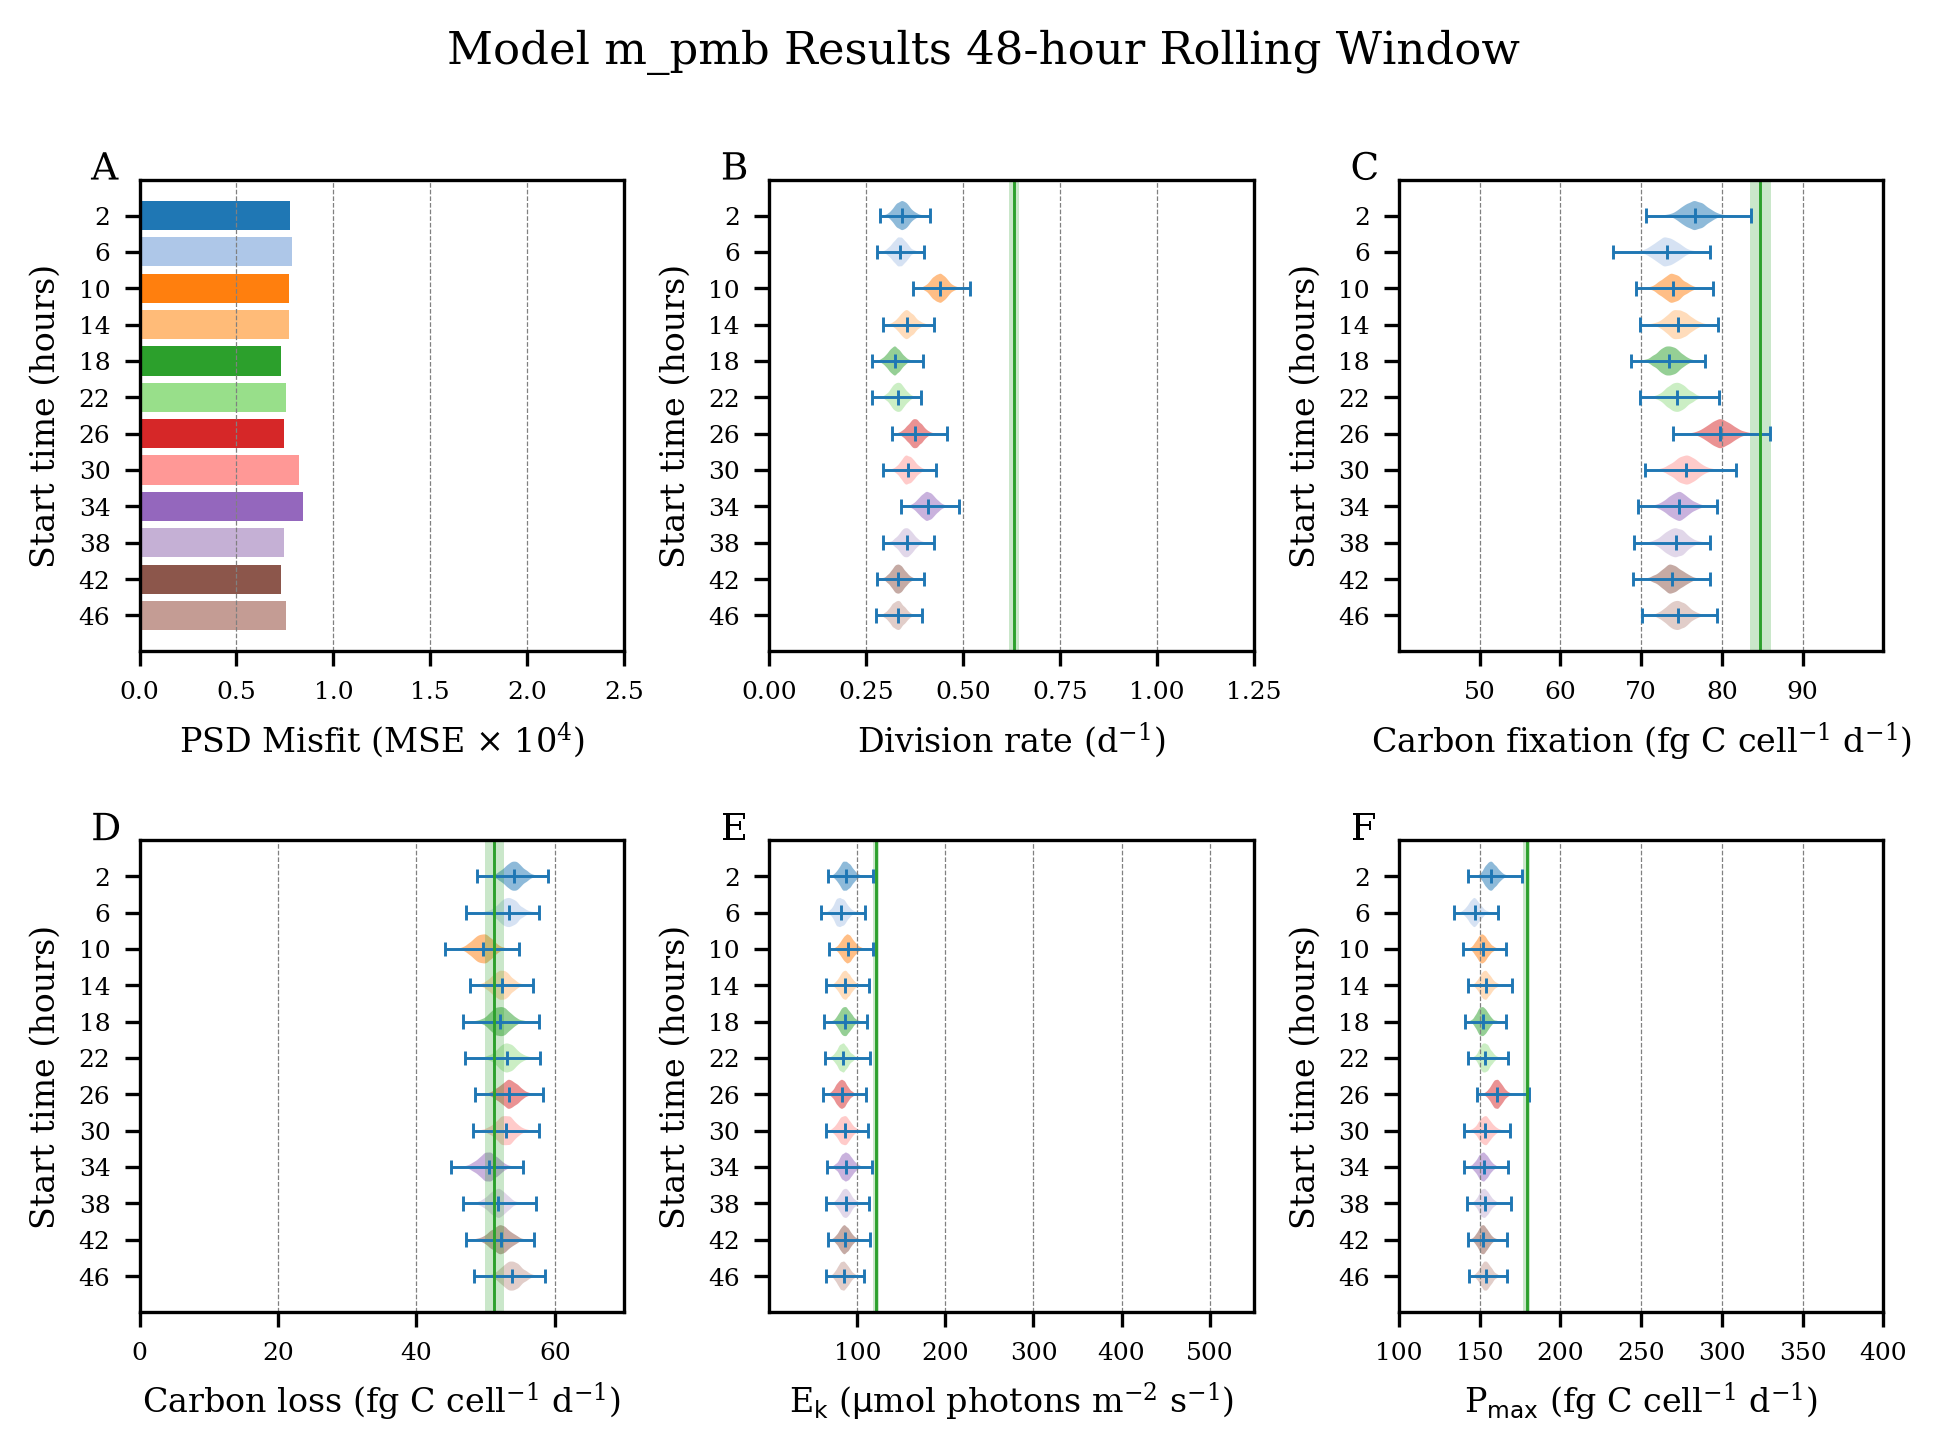

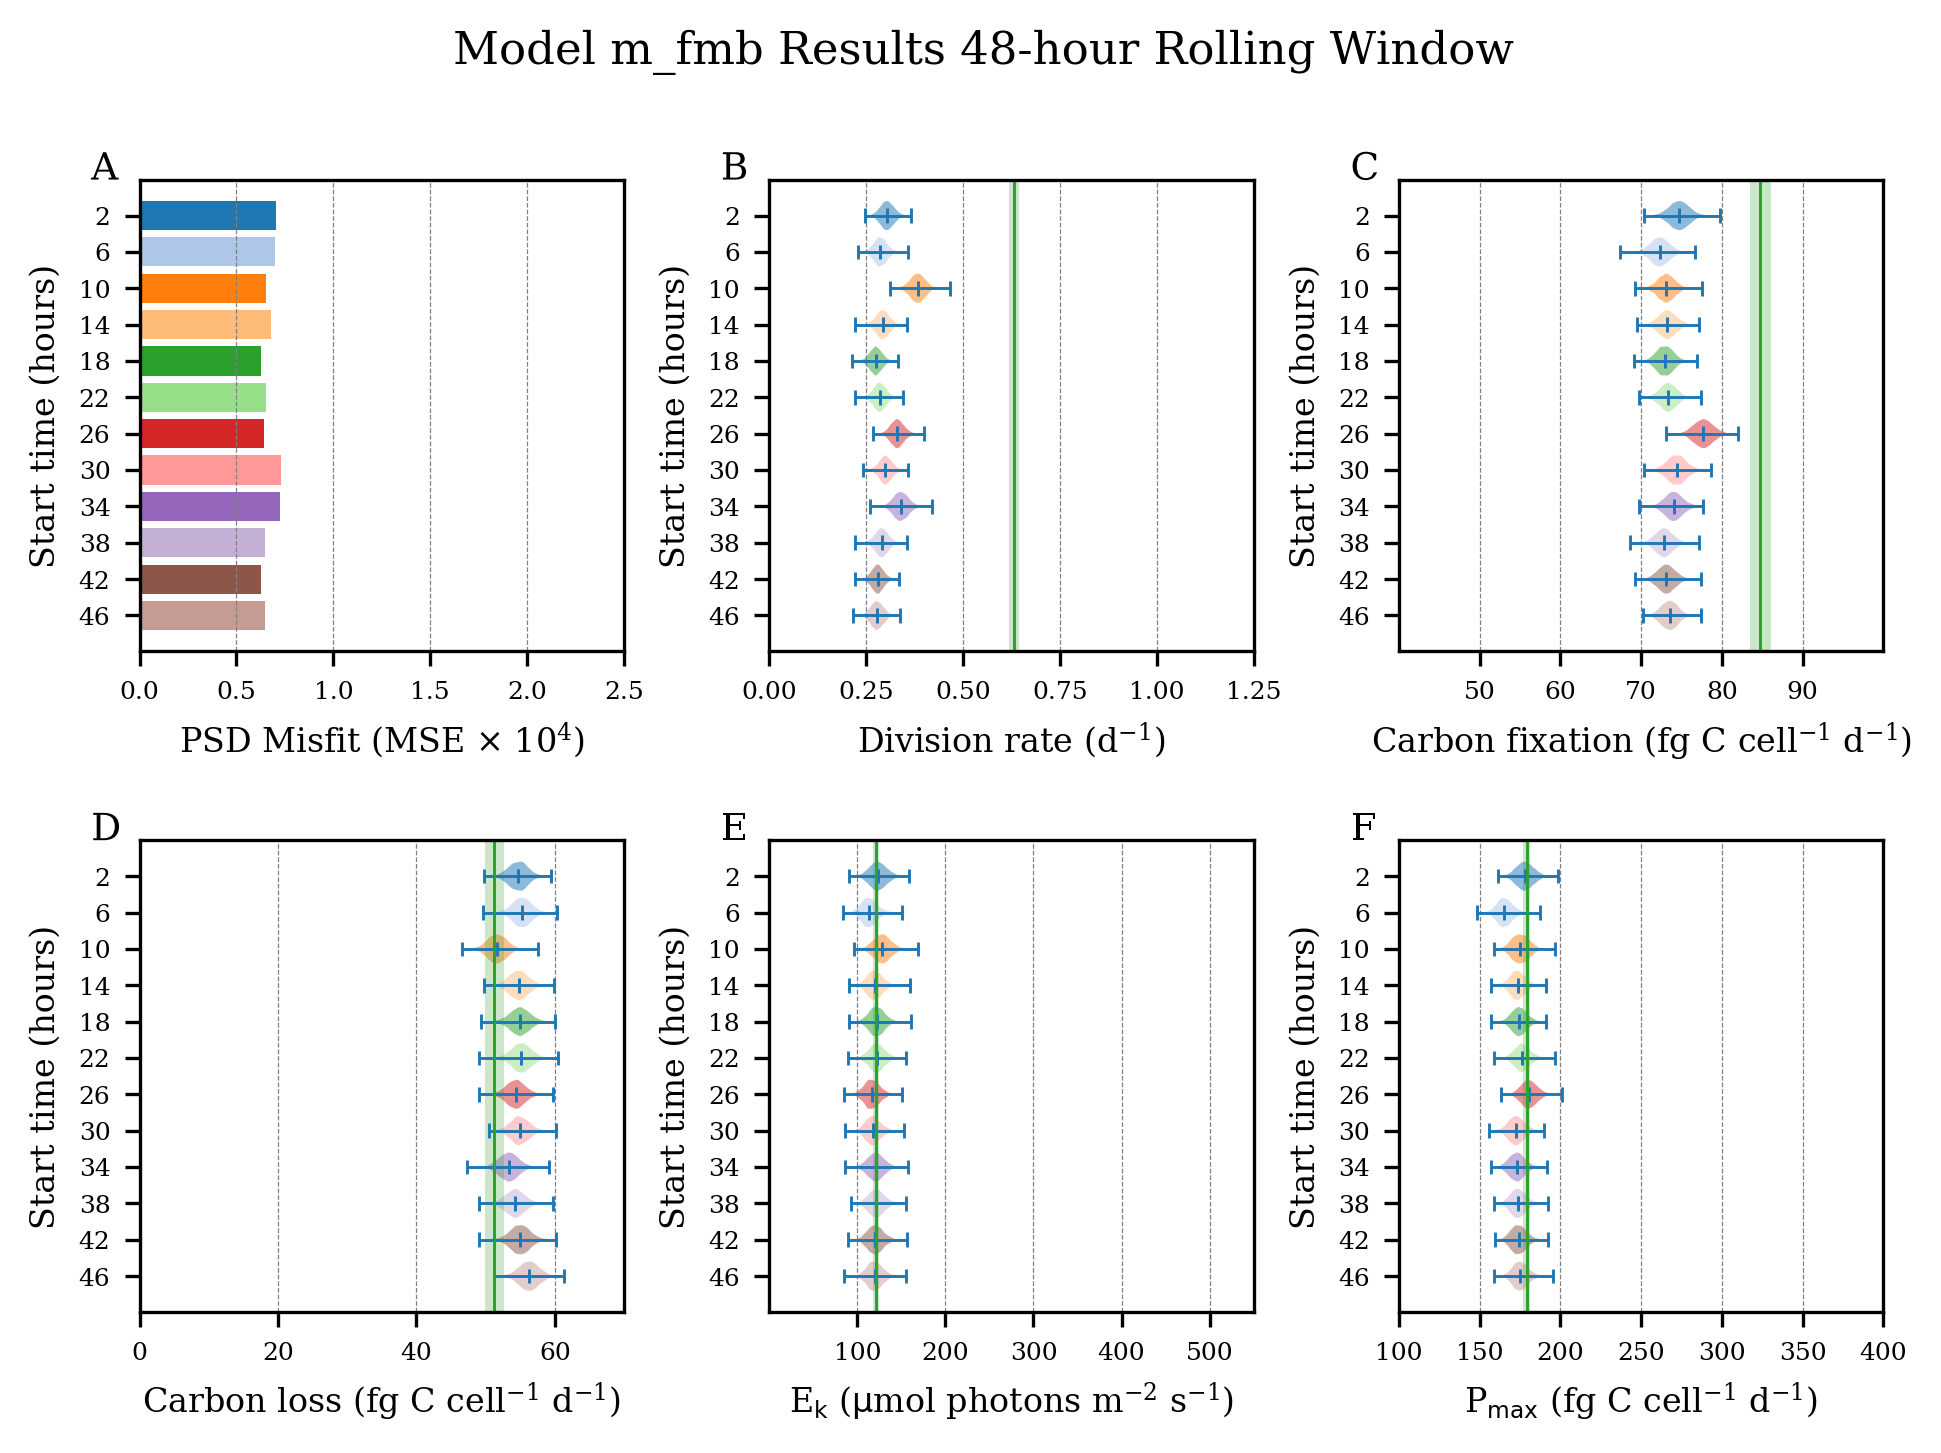

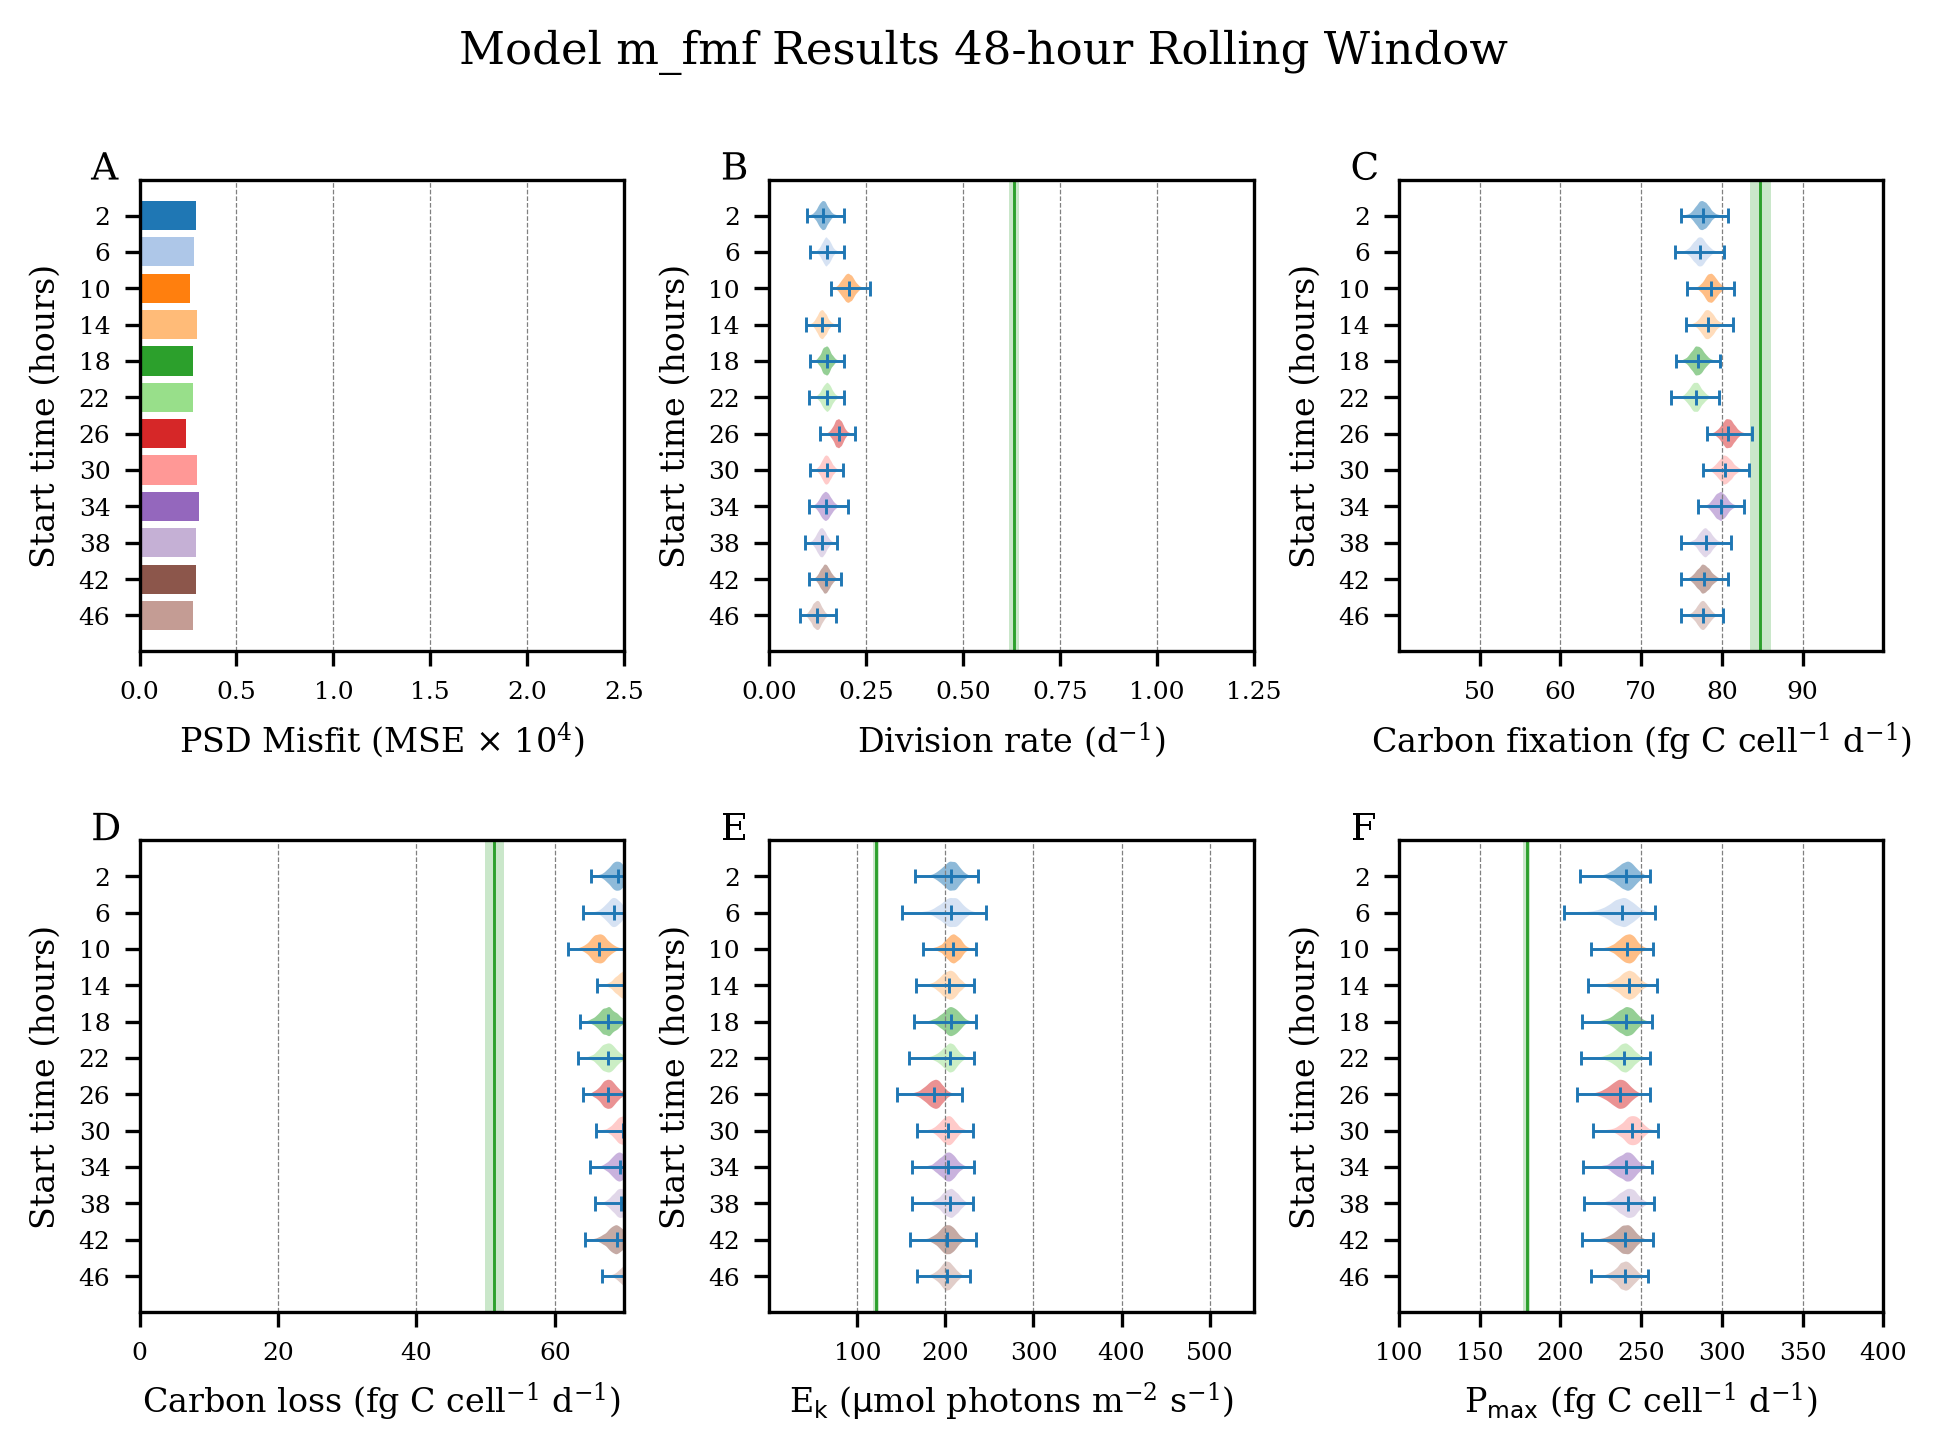

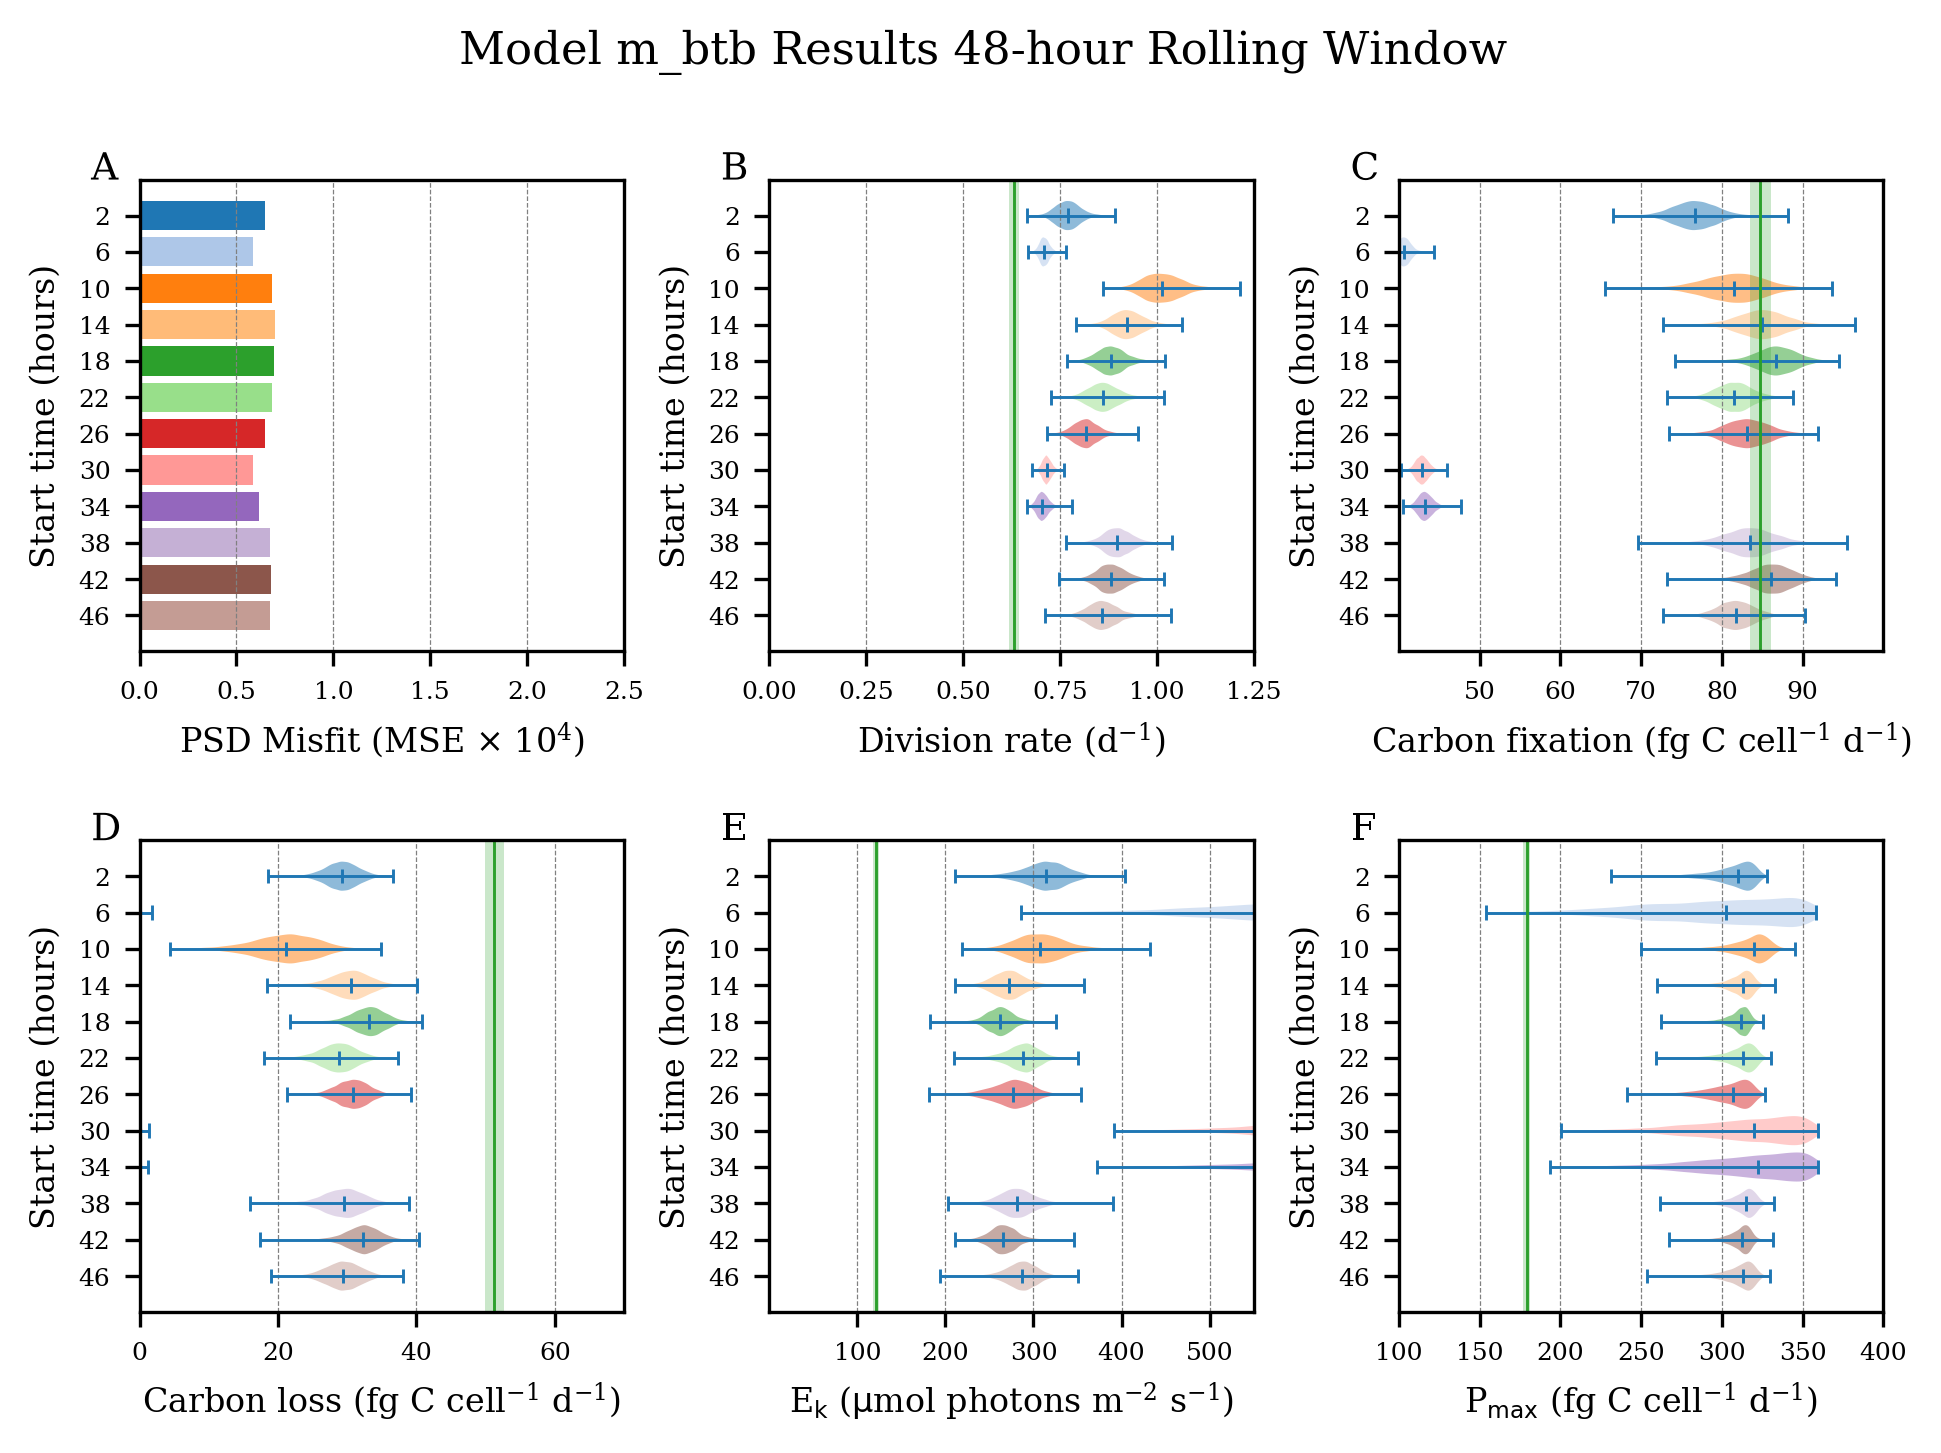

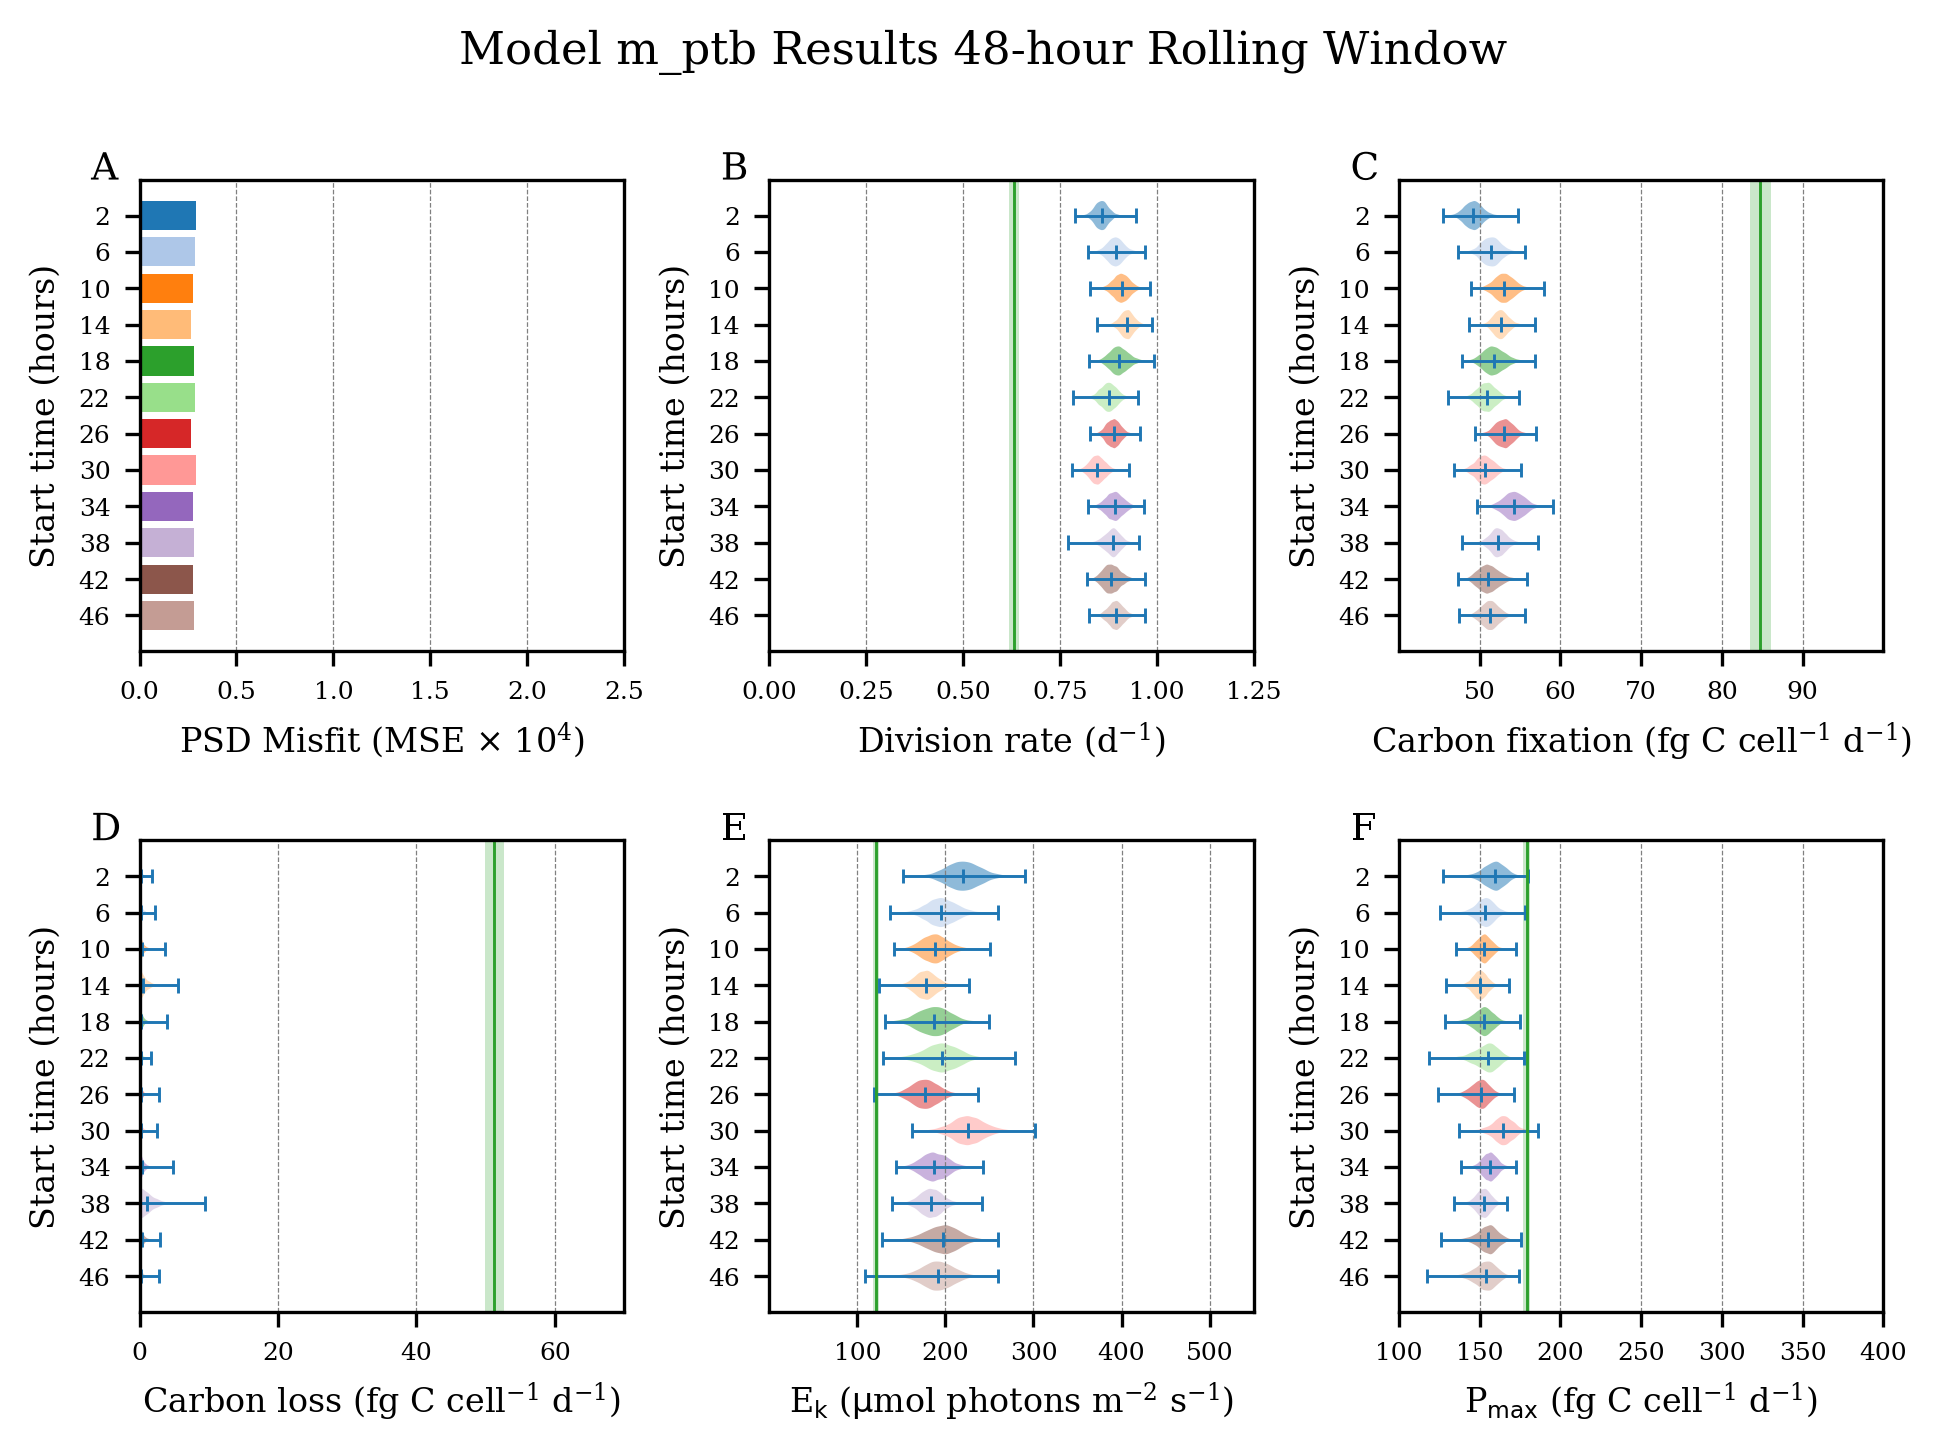

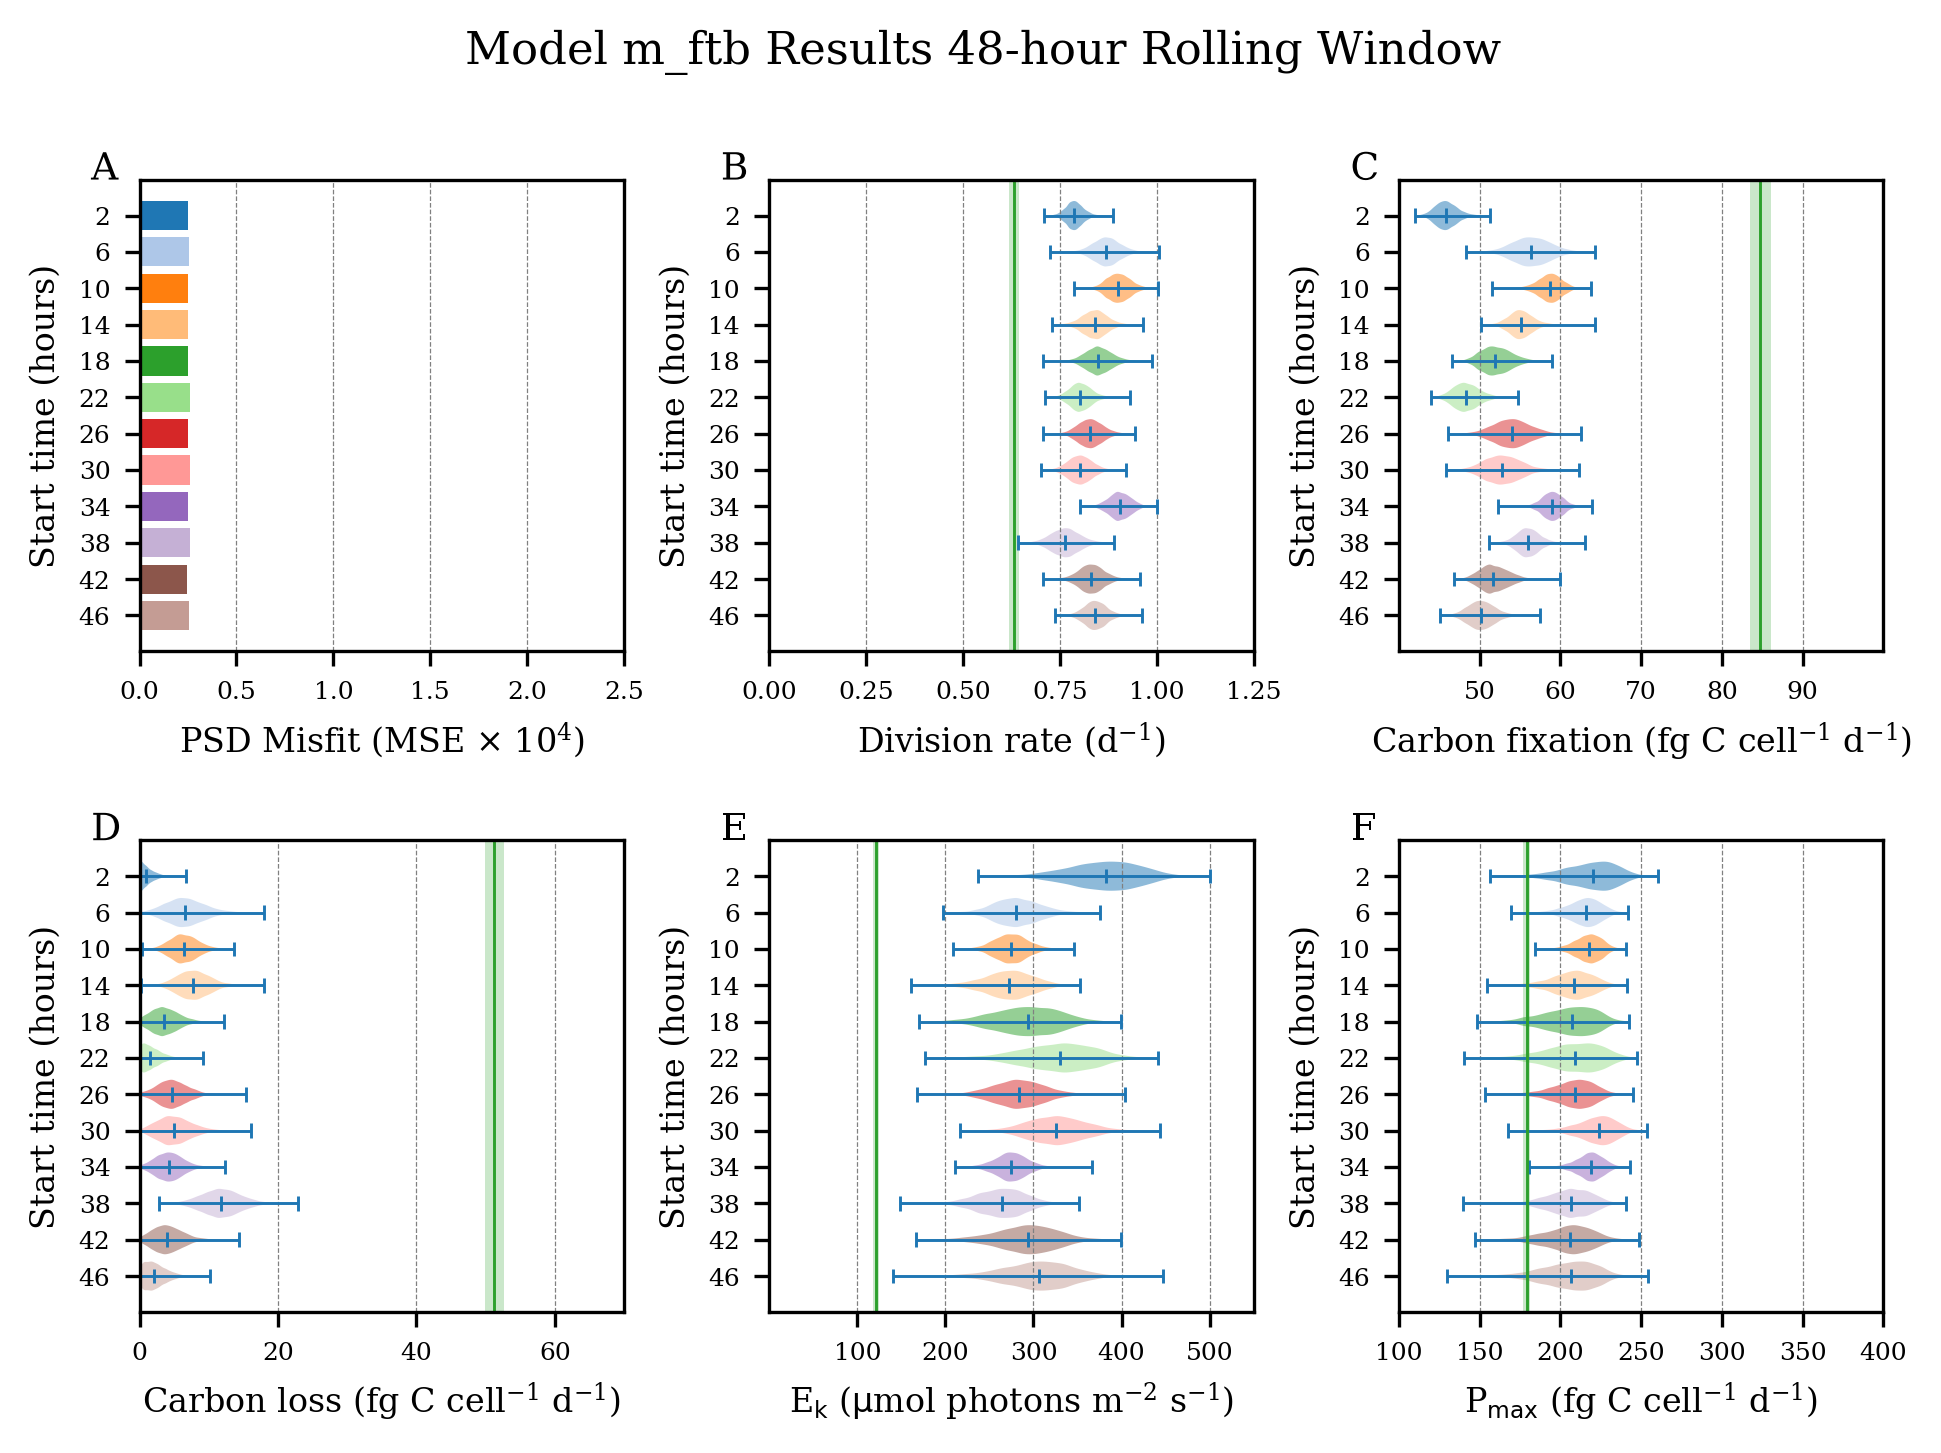

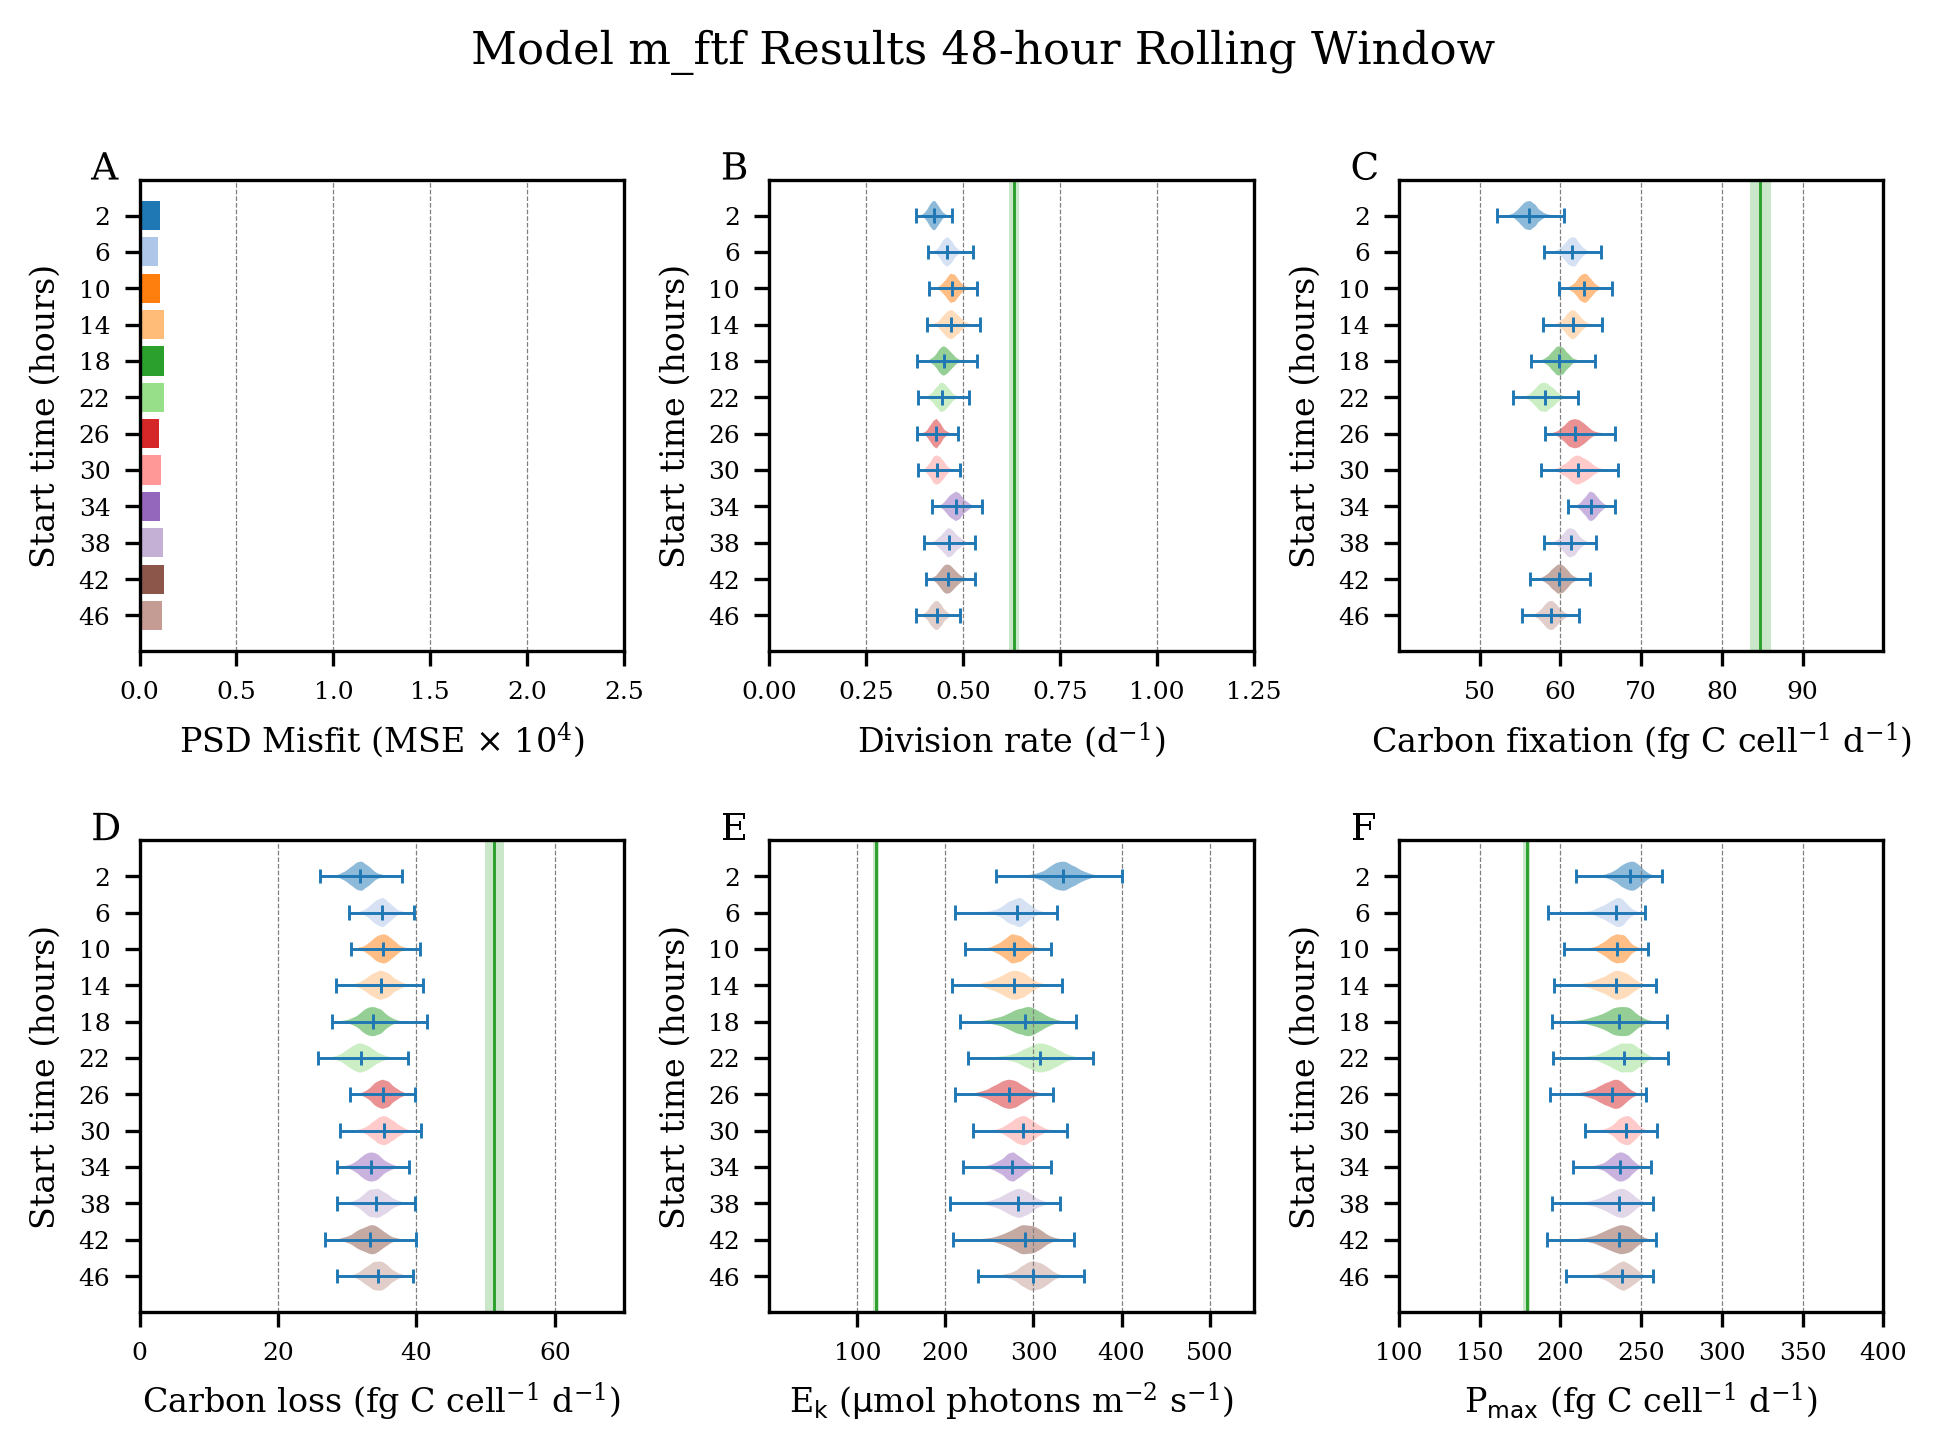

In [11]:
if 'size_units' not in globals():
    size_units = 'fg C cell$^{-1}$'

prop_labels = {
    'growth':'cell growth ({} h$^{{-1}}$)'.format(size_units),
    'division':'division rate (h$^{-1}$)',
    'respiration':'respiration + exudation\n({} h$^{{-1}}$)'.format(size_units),
}

fontsize = 9

# Panel label parameters
xtext = -0.1
ytext = 1
text_color = 'black'

# Ground truth plotting parameters
truth_lw = 0.7
truth_alpha = 0.25
truth_color = 'tab:green'

# Model results plotting parameters
widths = 0.8
linewidth = 0.7
violin_alpha = 0.5

# Plot grid parameters
show_grid = True
grid_width = 0.3
which_grid = 'both'
grid_axis = 'x'
grid_color = 'grey'
grid_style = '--'


# Helper functions
def get_misfit(mcmcs, data):
    obs = data['obs']
    ee = np.zeros(len(mcmcs))
    for ii, window in enumerate(mcmcs):
        start_time = int(window) // 2
        duration = len(mcmcs[window]['obstime'])
        mod_mean = np.mean(mcmcs[window]['mod_obspos'], axis=0)
        mod_mean /= np.sum(mod_mean, axis=0)
        ee[ii] = np.mean((mod_mean-obs[:, start_time:(start_time+duration)])**2)
    return ee


def color_violin(plot, colors, violin_alpha, linewidth):
    ii = 0
    for pc in plot['bodies']:
        if colors:
            pc.set_facecolor(colors[ii])
        pc.set_alpha(violin_alpha)
        ii += 1
    plot['cbars'].set_linewidth(linewidth)
    plot['cmins'].set_linewidth(linewidth)
    plot['cmaxes'].set_linewidth(linewidth)
    plot['cmedians'].set_linewidth(linewidth)
    return 0


def get_daily_props(mcmcs, prop, dt_h):
    
    res = {}

    for model in mcmcs:
        cell_count = mcmcs[model]['cell_count']
        if prop == 'growth':
            plotprop = mcmcs[model]['growth_size_gain']/cell_count/dt_h
        elif prop == 'respiration':
            plotprop = mcmcs[model]['resp_size_loss']/cell_count/dt_h
        else:
            raise ValueError('Unknown prop "{}"!'.format(prop))
        res[model] = np.mean(plotprop, axis=1)*24
    return res


# Plot rolling window results
for model in models:
    temp_mcmcs = mcmcs[model].copy()
    num_mcmcs = len(temp_mcmcs)
    duration = len(temp_mcmcs[tuple(temp_mcmcs.keys())[0]]['obstime'])
    fig, axs = plt.subplots(2, 3, figsize=(7.5,5))
    
    fig.suptitle('Model {} Results {}-hour Rolling Window'.format(model, np.round(duration*2)))


    # Specify arrangement of figure panels
    ax_misfit = axs[0, 0]
    ax_div = axs[0, 1]
    ax_grow = axs[0, 2]
    ax_resp = axs[1, 0]
    ax_estar = axs[1, 1]
    ax_pmax = axs[1, 2]


    # PSD misfit (MSE)
    cmap = plt.cm.get_cmap('tab20')
    colors = [cmap(ii) for ii in range(len(temp_mcmcs))]

    ax = ax_misfit

    ee = get_misfit(temp_mcmcs, data)

    ax.barh(y=np.arange(len(temp_mcmcs)), width=ee*10000, color=colors)

    ax.invert_yaxis()
    ax.text(xtext, ytext, 'A', transform=ax.transAxes, color=text_color,
            fontsize=fontsize,
            path_effects=[pe.Stroke(linewidth=1, foreground='w'), pe.Normal()])
    ax.set(yticks=np.arange(0, num_mcmcs),
           yticklabels=windows,
           xticks=np.linspace(0, 2.5, num=6))
    ax.set_xlabel(r'PSD Misfit (MSE $\times ~ 10^4$)')
    ax.grid(which=which_grid, axis=grid_axis, color=grid_color,
            linestyle=grid_style, linewidth=grid_width)
    ax.set_ylabel('Start time (hours)')


    # Daily division rates
    ax = ax_div

    plot = ax.violinplot([temp_mcmcs[window]['divrate']
                          for window in temp_mcmcs],
                         showmedians=True, vert=False, widths=widths)

    colors = [cmap(ii) for ii in range(len(temp_mcmcs))]

    color_violin(plot, colors, violin_alpha, linewidth)

    ax.invert_yaxis()
    ax.set(yticks=np.arange(1, num_mcmcs+1),
           yticklabels=windows,
           xlabel='Division rate (d$^{-1}$)')
    ax.set_xticks(np.linspace(0, 1.25, num=6), minor=False)

    ax.text(xtext, ytext, 'B', transform = ax.transAxes, color=text_color,
            fontsize=fontsize, path_effects=[pe.Stroke(linewidth=1, foreground='w'), pe.Normal()])
    ax.grid(which=which_grid, axis=grid_axis, color=grid_color, linestyle=grid_style, linewidth=grid_width)

    if 'zinser' in dataname:
        ax.axvline(ground_truth['dailydivision'], color=truth_color, lw=truth_lw)
        ax.axvspan(ground_truth['dailydivision']-ground_truth['dailydivision_sd'],
                   ground_truth['dailydivision']+ground_truth['dailydivision_sd'],
                   facecolor='tab:green', alpha=truth_alpha)
    ax.set_ylabel('Start time (hours)')
    ax.set_xlim(0, 1.25)


    # Daily growth/respiration
    dt_h = data['dt'] / 60.0
    daily_props = {}
    xlabels = {'growth': 'Carbon fixation ({} d$^{{-1}}$)'.format(size_units),
               'respiration': 'Carbon loss ({} d$^{{-1}}$)'.format(size_units)}
    labels = {'growth': 'C', 'respiration': 'D'}
    par_string = {'growth': 'carbonfix', 'respiration': 'carbonloss'}

    for prop in ('growth', 'respiration'):

        daily_props[prop] = get_daily_props(temp_mcmcs, prop, dt_h)

        if prop == 'respiration':
            ax = ax_resp
            plot = ax.violinplot([daily_props[prop][window]
                                  for window in daily_props[prop]],
                                 showmedians=True, vert=False, widths=widths)

            colors = [cmap(ii) for ii in range(len(temp_mcmcs))]

            ax.set_yticks(np.arange(1, num_mcmcs+1))
            ax.set_xticks(np.linspace(0, 60, num=4))
            ax.set_xlim(0, 70)

        elif prop == 'growth':

            ax = ax_grow

            plot = ax.violinplot([daily_props[prop][window]
                                  for window in daily_props[prop]],
                                 showmedians=True, vert=False, widths=widths)

            colors = [cmap(ii) for ii in range(len(temp_mcmcs))]

            ax.set_yticks(np.arange(1, num_mcmcs+1))
            ax.set_xticks(np.linspace(50, 90, num=5))
            ax.set_xlim(40, 100)

        ax.set(yticklabels=windows,
               xlabel=xlabels[prop])
        ax.invert_yaxis()

        color_violin(plot, colors, violin_alpha, linewidth)

        ax.text(xtext, ytext, labels[prop], transform = ax.transAxes,
                color=text_color, fontsize=fontsize,
                path_effects=[pe.Stroke(linewidth=1, foreground='w'), pe.Normal()])
        ax.grid(which=which_grid, axis=grid_axis, color=grid_color,
                linestyle=grid_style, linewidth=grid_width)

        ax.axvline(ground_truth['daily' + par_string[prop]],
                   color=truth_color, lw=truth_lw)
        ax.axvspan(ground_truth['daily' + par_string[prop]]
                   - ground_truth['daily' + par_string[prop] + '_sd'],
                   ground_truth['daily' + par_string[prop]]
                   + ground_truth['daily' + par_string[prop] + '_sd'],
                   facecolor='tab:green', alpha=truth_alpha)
        ax.set_ylabel('Start time (hours)')


    # Ek/Estar
    ax = ax_estar

    linewidth = 0.7

    plot = ax.violinplot([temp_mcmcs[window]['E_star']
                          for window in temp_mcmcs],
                         showmedians=True, vert=False, widths=0.8)
    colors = [cmap(ii) for ii in range(len(temp_mcmcs))]

    color_violin(plot, colors, violin_alpha, linewidth)

    ax.invert_yaxis()
    ax.set(yticks=np.arange(1, num_mcmcs+1),
           yticklabels=windows,
           xlabel='E$_\mathrm{k}$ ($\mathrm{\mu}$mol photons m$^{-2}$ s$^{-1}$)')
    ax.set_xticks(np.linspace(100, 500, num=5), minor=False)

    ax.text(xtext, ytext, 'E', transform = ax.transAxes, color=text_color,
            fontsize=fontsize,
            path_effects=[pe.Stroke(linewidth=1, foreground='w'), pe.Normal()])
    ax.grid(which=which_grid, axis=grid_axis, color=grid_color,
            linestyle=grid_style, linewidth=grid_width)

    true_Estar = np.mean(np.asarray(zinser_fig3['Estar']))
    Estar_sd = np.sqrt(np.sum(np.asarray(zinser_fig3['Estar-sd'])**2)
                       / (np.asarray(zinser_fig3['Estar-sd']).shape[0]**2))
    ax.axvline(true_Estar, color=truth_color, lw=truth_lw)
    ax.axvspan(true_Estar - Estar_sd, true_Estar + Estar_sd,
               facecolor=truth_color, alpha=truth_alpha)
    ax.set_ylabel('Start time (hours)')
    ax.set_xlim(0, 550)


    # Pmax
    ax = ax_pmax

    t = data['dt']*np.arange(data['nt'])/60.0
    dt_h = data['dt']/60.0
    linewidth = 0.7

    pmax = [np.mean(temp_mcmcs[window]['max_size_gain']
                    / temp_mcmcs[window]['cell_count'] / dt_h,
                    axis=1) * 24 for window in temp_mcmcs]

    plot = ax.violinplot(pmax, showmedians=True, vert=False, widths=0.8)

    # colors = [colors_model[model] for model in temp_mcmcs]
    colors = [cmap(ii) for ii in range(len(temp_mcmcs))]

    color_violin(plot, colors, violin_alpha, linewidth)

    ax.invert_yaxis()
    ax.set(yticks=np.arange(1, num_mcmcs+1),
           yticklabels=windows,
           xlabel='P$_\max$ (fg C cell$^{-1}$ d$^{-1}$)')

    ax.text(xtext, ytext, 'F', transform = ax.transAxes, color=text_color,
            fontsize=fontsize,
            path_effects=[pe.Stroke(linewidth=1, foreground='w'), pe.Normal()])
    ax.grid(which=which_grid, axis=grid_axis, color=grid_color,
            linestyle=grid_style, linewidth=grid_width)

    true_pmax = np.mean(np.asarray(zinser_fig3['Pmax'])) * 24
    pmax_sd = np.sqrt(np.sum(np.asarray(zinser_fig3['Pmax-sd'])**2)
                      / (np.asarray(zinser_fig3['Pmax-sd']).shape[0]**2)) * 24
    ax.axvline(true_pmax, color=truth_color, lw=truth_lw)
    ax.axvspan(true_pmax-pmax_sd, true_pmax+pmax_sd, facecolor=truth_color,
               alpha=truth_alpha)
    ax.set_ylabel('Start time (hours)')
    ax.set_xlim(100, 400)
    

    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    if save_plots:
        plt.savefig('../figures/rollingwindow{}{}.pdf'.format(model, duration), bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

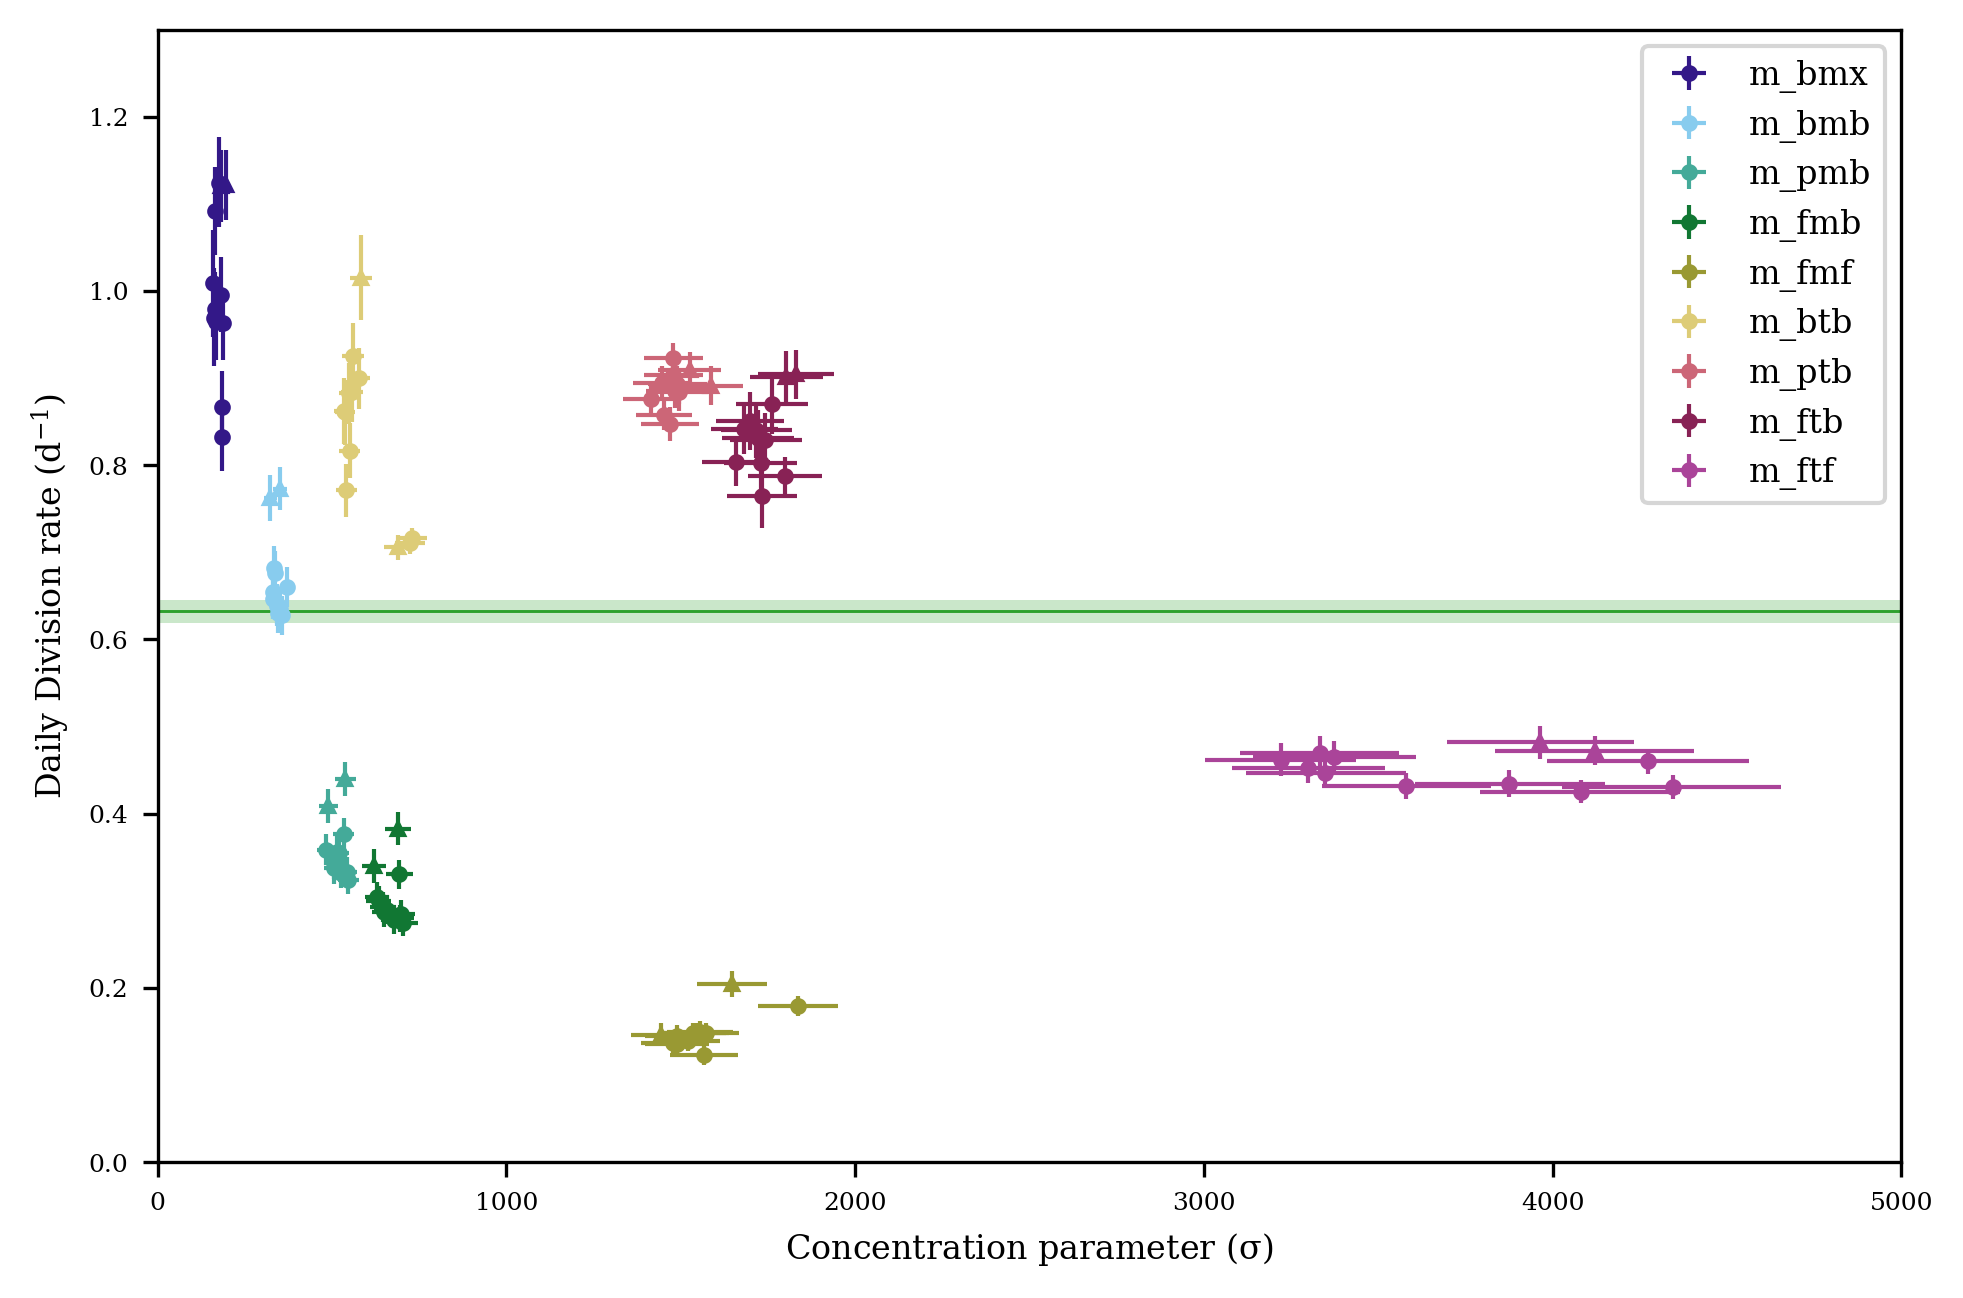

In [12]:
# Uncertainty interval coverage
coverage = 0.68
lower = (1 - coverage)/2
upper = 1 - lower

div_means = {}
div_quant = {}
div_means_peak = {}
div_quant_peak = {}
sigma_means = {}
sigma_quant = {}
sigma_means_peak = {}
sigma_quant_peak = {}
for model in models:
    div_means[model] = []
    div_quant[model] = []
    div_means_peak[model] = []
    div_quant_peak[model] = []
    sigma_means[model] = []
    sigma_quant[model] = []
    sigma_means_peak[model] = []
    sigma_quant_peak[model] = []
    for window in mcmcs[model].keys():
        if window == '10' or window == '34':
            div_means_peak[model].append(np.mean(mcmcs[model][window]['divrate']))
            div_quant_peak[model].append(np.quantile(mcmcs[model][window]['divrate'],
                                                     [lower, upper]))
            sigma_means_peak[model].append(np.mean(mcmcs[model][window]['sigma']))
            sigma_quant_peak[model].append(np.quantile(mcmcs[model][window]['sigma'],
                                                       [lower, upper]))
        else:
            div_means[model].append(np.mean(mcmcs[model][window]['divrate']))
            div_quant[model].append(np.quantile(mcmcs[model][window]['divrate'],
                                                [lower, upper]))
            sigma_means[model].append(np.mean(mcmcs[model][window]['sigma']))
            sigma_quant[model].append(np.quantile(mcmcs[model][window]['sigma'],
                                                  [lower, upper]))

fig = plt.figure(figsize=(7.5,5))

# Color blind-friendly model color coding scheme
color_palette = {
    'm_bmx': (51/255, 24/255, 136/255),
    'm_bmb': (136/255, 204/255, 238/255),
    'm_pmb': (68/255, 170/255, 153/255),
    'm_fmb': (17/255, 119/255, 51/255),
    'm_fmf': (153/255, 153/255, 51/255),
    'm_btb': (221/255, 204/255, 119/255),
    'm_ptb': (204/255, 102/255, 119/255),
    'm_ftb': (136/255, 34/255, 85/255),
    'm_ftf': (170/255, 68/255, 153/255),
}
        
for model in models:
    plt.xlim(0, 5000)
    plt.ylim(0, 1.3)
    plt.errorbar(sigma_means[model], div_means[model],
                 yerr=np.abs(np.asarray(div_quant[model]).T - np.asarray(div_means[model])),
                 xerr=np.abs(np.asarray(sigma_quant[model]).T - np.asarray(sigma_means[model])),
                 color=color_palette[model], fmt='o', lw=1)
plt.xlabel('Concentration parameter ($\sigma$)')
plt.ylabel('Daily Division rate (d$^{-1}$)')
plt.legend(models)
for model in models:
    plt.xlim(0, 5000)
    plt.ylim(0, 1.3)
    plt.errorbar(sigma_means_peak[model], div_means_peak[model],
                 yerr=np.abs(np.asarray(div_quant_peak[model]).T - np.asarray(div_means_peak[model])),
                 xerr=np.abs(np.asarray(sigma_quant_peak[model]).T - np.asarray(sigma_means_peak[model])),
                 color=color_palette[model], marker='^', fmt='o', lw=1)
plt.axhline(ground_truth['dailydivision'], color=truth_color, lw=truth_lw)
plt.axhspan(ground_truth['dailydivision']-ground_truth['dailydivision_sd'],
            ground_truth['dailydivision']+ground_truth['dailydivision_sd'],
            facecolor='tab:green', alpha=truth_alpha)
if save_plots:
    plt.savefig('../figures/rollingwindow_concentration.pdf', bbox_inches='tight', dpi=300)
plt.show()
plt.close('all')